## Import packages

In [1]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
from torch import nn                                    # Neural network modules
from torch.utils.data import Dataset, DataLoader        # Dataset and batch data loading
from datetime import datetime                           # Date/time utilities
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

import deepSSF_model                                    # Import the .py file containing the deepSSF model     
import deepSSF_loss                                     # Import the .py file containing the deepSSF loss function
import deepSSF_early_stopping                           # Import the .py file containing the early stopping function                                     

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Set random seed for reproducibility
seed = 42

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import data

## Set paths to data

In [3]:
buffalo_id = 2005
n_samples = 10297

# Specify the path to CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Path to your TIF file (slope)
slope_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_slope_cent101x101_lag_1hr_n{n_samples}.tif'

# Paths to the Sentinel-2 bands
b1_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b1_cent101x101_lag_1hr_n{n_samples}.tif'
b2_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b2_cent101x101_lag_1hr_n{n_samples}.tif'
b3_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b3_cent101x101_lag_1hr_n{n_samples}.tif'
b4_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b4_cent101x101_lag_1hr_n{n_samples}.tif'
b5_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b5_cent101x101_lag_1hr_n{n_samples}.tif'
b6_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b6_cent101x101_lag_1hr_n{n_samples}.tif'
b7_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b7_cent101x101_lag_1hr_n{n_samples}.tif'
b8_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8_cent101x101_lag_1hr_n{n_samples}.tif'
b8a_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8a_cent101x101_lag_1hr_n{n_samples}.tif'
b9_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b9_cent101x101_lag_1hr_n{n_samples}.tif'
b11_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b11_cent101x101_lag_1hr_n{n_samples}.tif'
b12_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b12_cent101x101_lag_1hr_n{n_samples}.tif'

# Path to your TIF file (target variable)
pres_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_pres_cent101x101_lag_1hr_n{n_samples}.tif'


## Read buffalo data

In [4]:
# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index to get the bearing of the previous step
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 35)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

     cos_ta         x_min         x_max         y_min         y_max  s2_index  \
0  0.

## Importing spatial data

## Slope

In [5]:
# Using rasterio
with rasterio.open(slope_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [6]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)

# Print the mean, max, and min values of the slope tensor
print("Mean = ", torch.mean(slope_tens))
slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)
print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens))
print("Max = ", torch.max(slope_tens))
print("Min = ", torch.min(slope_tens))

torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


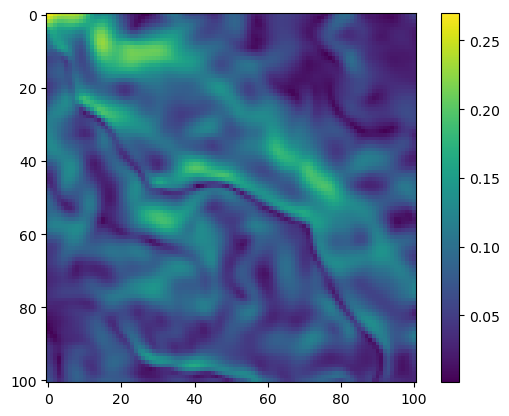

In [7]:
for i in range(0, 1):
    plt.imshow(slope_tens[i])
    plt.colorbar()
    plt.show()

## Sentinel-2 bands

During the data preparation (in the `deepSSF_data_prep_id_S2` script) for the Sentinel-2 bands, we scaled them by 10,000, so we do not need to scale them again here (as we did for the other covariates). 

### Band 1

In [8]:
# Using rasterio
with rasterio.open(b1_path) as b1:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b1_stack = b1.read([i for i in range(1, b1.count + 1)])

In [9]:
# Print the shape of the original b1_stack array
print(b1_stack.shape)

# Replace NaNs with -1
b1_stack = np.nan_to_num(b1_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b1_tens = torch.from_numpy(b1_stack)
print(b1_tens.shape)

# Display the mean, max, and min values of the b1 tensor
print(f'Min =  {torch.min(b1_tens)}')
print(f'Mean = {torch.mean(b1_tens)}')
print(f'Max =  {torch.max(b1_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  9.999999747378752e-05
Mean = 0.04444880783557892
Max =  0.1517084836959839


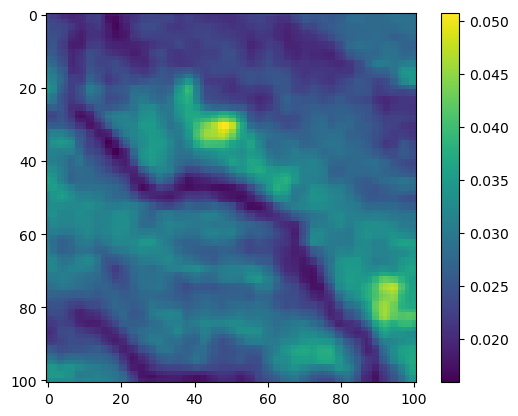

In [10]:
for i in range(0, 1):
    plt.imshow(b1_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 2

In [11]:
# Using rasterio
with rasterio.open(b2_path) as b2:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b2_stack = b2.read([i for i in range(1, b2.count + 1)])

In [12]:
# Print the shape of the original b2_stack array
print(b2_stack.shape)

# Replace NaNs with -1
b2_stack = np.nan_to_num(b2_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b2_tens = torch.from_numpy(b2_stack)
print(b2_tens.shape)

# Display the mean, max, and min values of the b2 tensor
print(f'Min =  {torch.min(b2_tens)}')
print(f'Mean = {torch.mean(b2_tens)}')
print(f'Max =  {torch.max(b2_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.002810720121487975
Mean = 0.05629923567175865
Max =  0.1931755244731903


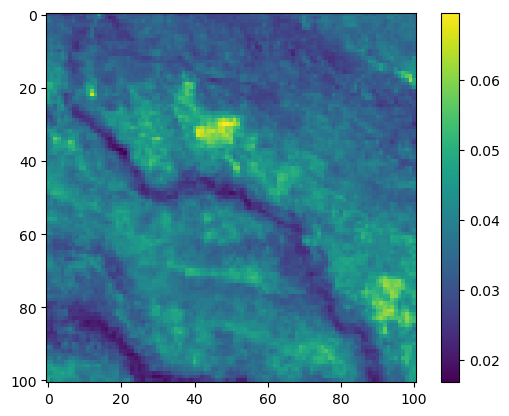

In [13]:
for i in range(0, 1):
    plt.imshow(b2_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 3

In [14]:
# Using rasterio
with rasterio.open(b3_path) as b3:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b3_stack = b3.read([i for i in range(1, b3.count + 1)])

In [15]:
# Print the shape of the original b3_stack array
print(b3_stack.shape)

# Replace NaNs with -1
b3_stack = np.nan_to_num(b3_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b3_tens = torch.from_numpy(b3_stack)
print(b3_tens.shape)

# Display the mean, max, and min values of the b3 tensor
print(f'Min =  {torch.min(b3_tens)}')
print(f'Mean = {torch.mean(b3_tens)}')
print(f'Max =  {torch.max(b3_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.02109863981604576
Mean = 0.08027872443199158
Max =  0.2795756757259369


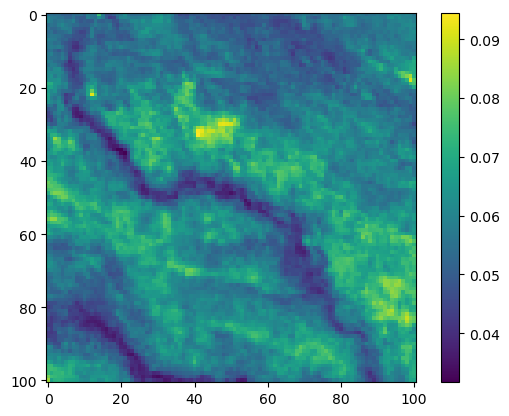

In [16]:
for i in range(0, 1):
    plt.imshow(b3_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 4

In [17]:
# Using rasterio
with rasterio.open(b4_path) as b4:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b4_stack = b4.read([i for i in range(1, b4.count + 1)])

In [18]:
# Print the shape of the original b4_stack array
print(b4_stack.shape)

# Replace NaNs with -1
b4_stack = np.nan_to_num(b4_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b4_tens = torch.from_numpy(b4_stack)
print(b4_tens.shape)

# Display the mean, max, and min values of the b4 tensor
print(f'Min =  {torch.min(b4_tens)}')
print(f'Mean = {torch.mean(b4_tens)}')
print(f'Max =  {torch.max(b4_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.006578320171684027
Mean = 0.09937984496355057
Max =  0.43867969512939453


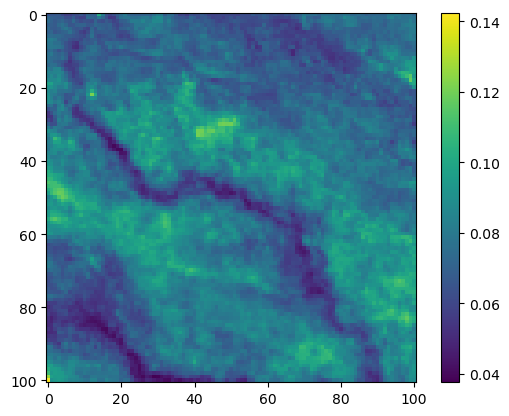

In [19]:
for i in range(0, 1):
    plt.imshow(b4_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 5

In [20]:
# Using rasterio
with rasterio.open(b5_path) as b5:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b5_stack = b5.read([i for i in range(1, b5.count + 1)])

In [21]:
# Print the shape of the original b5_stack array
print(b5_stack.shape)

# Replace NaNs with -1
b5_stack = np.nan_to_num(b5_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b5_tens = torch.from_numpy(b5_stack)
print(b5_tens.shape)

# Display the mean, max, and min values of the b5 tensor
print(f'Min =  {torch.min(b5_tens)}')
print(f'Mean = {torch.mean(b5_tens)}')
print(f'Max =  {torch.max(b5_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03587600216269493
Mean = 0.136901393532753
Max =  0.4592735767364502


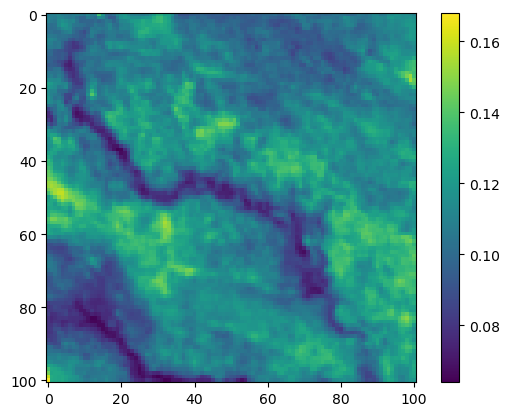

In [22]:
for i in range(0, 1):
    plt.imshow(b5_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 6

In [23]:
# Using rasterio
with rasterio.open(b6_path) as b6:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b6_stack = b6.read([i for i in range(1, b6.count + 1)])

In [24]:
# Print the shape of the original b6_stack array
print(b6_stack.shape)

# Replace NaNs with -1
b6_stack = np.nan_to_num(b6_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b6_tens = torch.from_numpy(b6_stack)
print(b6_tens.shape)

# Display the mean, max, and min values of the b6 tensor
print(f'Min =  {torch.min(b6_tens)}')
print(f'Mean = {torch.mean(b6_tens)}')
print(f'Max =  {torch.max(b6_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.038534000515937805
Mean = 0.17727355659008026
Max =  0.5120914578437805


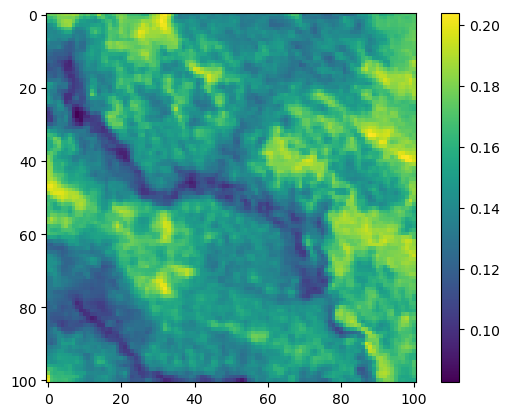

In [25]:
for i in range(0, 1):
    plt.imshow(b6_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 7

In [26]:
# Using rasterio
with rasterio.open(b7_path) as b7:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b7_stack = b7.read([i for i in range(1, b7.count + 1)])

In [27]:
# Print the shape of the original b7_stack array
print(b7_stack.shape)

# Replace NaNs with -1
b7_stack = np.nan_to_num(b7_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b7_tens = torch.from_numpy(b7_stack)
print(b7_tens.shape)

# Display the mean, max, and min values of the b7 tensor
print(f'Min =  {torch.min(b7_tens)}')
print(f'Mean = {torch.mean(b7_tens)}')
print(f'Max =  {torch.max(b7_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.04165744036436081
Mean = 0.19983430206775665
Max =  0.6045699119567871


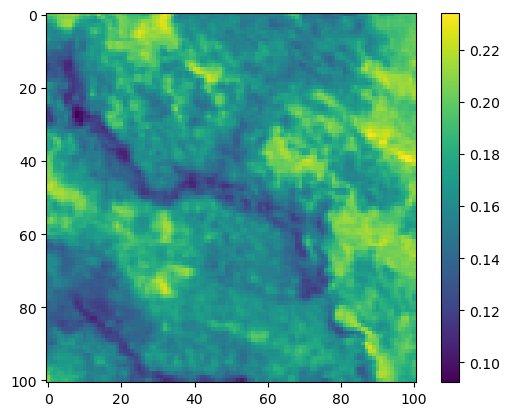

In [28]:
for i in range(0, 1):
    plt.imshow(b7_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8

In [29]:
# Using rasterio
with rasterio.open(b8_path) as b8:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8_stack = b8.read([i for i in range(1, b8.count + 1)])

In [30]:
# Print the shape of the original b8_stack array
print(b8_stack.shape)

# Replace NaNs with -1
b8_stack = np.nan_to_num(b8_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b8_tens = torch.from_numpy(b8_stack)
print(b8_tens.shape)

# Display the mean, max, and min values of the b8 tensor
print(f'Min =  {torch.min(b8_tens)}')
print(f'Mean = {torch.mean(b8_tens)}')
print(f'Max =  {torch.max(b8_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03680320084095001
Mean = 0.2095790058374405
Max =  0.6004582643508911


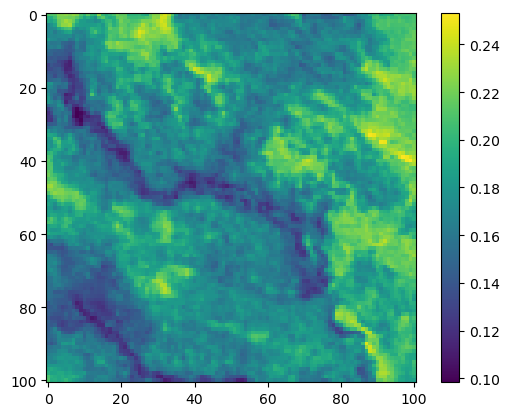

In [31]:
for i in range(0, 1):
    plt.imshow(b8_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8a

In [32]:
# Using rasterio
with rasterio.open(b8a_path) as b8a:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8a_stack = b8a.read([i for i in range(1, b8a.count + 1)])

In [33]:
# Print the shape of the original b8a_stack array
print(b8a_stack.shape)

# Replace NaNs with -1
b8a_stack = np.nan_to_num(b8a_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b8a_tens = torch.from_numpy(b8a_stack)
print(b8a_tens.shape)

# Display the mean, max, and min values of the b8a tensor
print(f'Min =  {torch.min(b8a_tens)}')
print(f'Mean = {torch.mean(b8a_tens)}')
print(f'Max =  {torch.max(b8a_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03570704162120819
Mean = 0.22782425582408905
Max =  0.6218413710594177


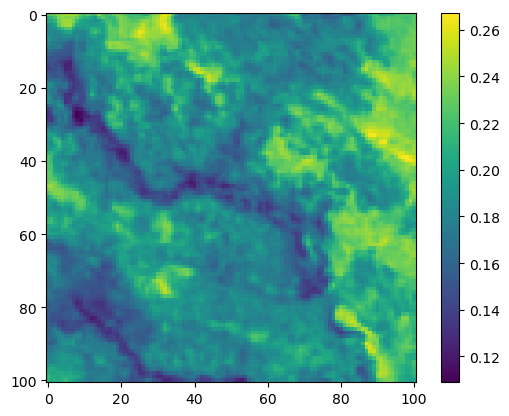

In [34]:
for i in range(0, 1):
    plt.imshow(b8a_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 9

In [35]:
# Using rasterio
with rasterio.open(b9_path) as b9:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b9_stack = b9.read([i for i in range(1, b9.count + 1)])

In [36]:
# Print the shape of the original b9_stack array
print(b9_stack.shape)

# Replace NaNs with -1
b9_stack = np.nan_to_num(b9_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b9_tens = torch.from_numpy(b9_stack)
print(b9_tens.shape)

# Display the mean, max, and min values of the b9 tensor
print(f'Min =  {torch.min(b9_tens)}')
print(f'Mean = {torch.mean(b9_tens)}')
print(f'Max =  {torch.max(b9_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.012299999594688416
Mean = 0.22701694071292877
Max =  0.5680500268936157


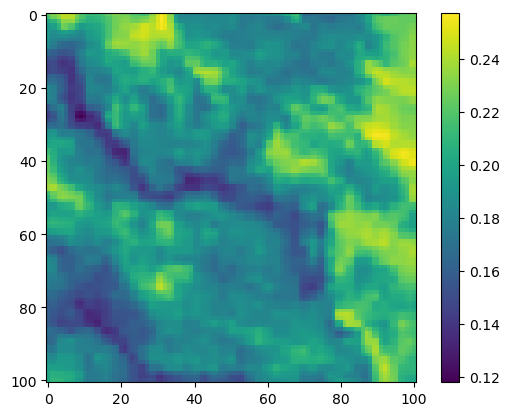

In [37]:
for i in range(0, 1):
    plt.imshow(b9_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 11

In [38]:
# Using rasterio
with rasterio.open(b11_path) as b11:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b11_stack = b11.read([i for i in range(1, b11.count + 1)])

In [39]:
# Print the shape of the original b11_stack array
print(b11_stack.shape)

# Replace NaNs with -1
b11_stack = np.nan_to_num(b11_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b11_tens = torch.from_numpy(b11_stack)
print(b11_tens.shape)

# Display the mean, max, and min values of the b11 tensor
print(f'Min =  {torch.min(b11_tens)}')
print(f'Mean = {torch.mean(b11_tens)}')
print(f'Max =  {torch.max(b11_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.01741199940443039
Mean = 0.27866700291633606
Max =  0.657039225101471


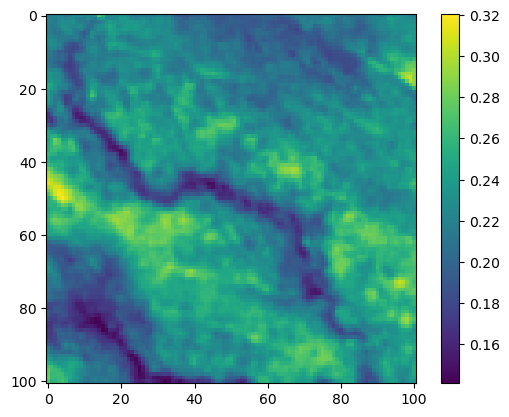

In [40]:
for i in range(0, 1):
    plt.imshow(b11_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 12

In [41]:
# Using rasterio
with rasterio.open(b12_path) as b12:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b12_stack = b12.read([i for i in range(1, b1.count + 1)])

In [42]:
# Print the shape of the original b12_stack array
print(b12_stack.shape)

# Replace NaNs with -1
b12_stack = np.nan_to_num(b12_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b12_tens = torch.from_numpy(b12_stack)
print(b12_tens.shape)

# Display the mean, max, and min values of the b12 tensor
print(f'Min =  {torch.min(b12_tens)}')
print(f'Mean = {torch.mean(b12_tens)}')
print(f'Max =  {torch.max(b12_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.012337599880993366
Mean = 0.19245100021362305
Max =  0.5119996666908264


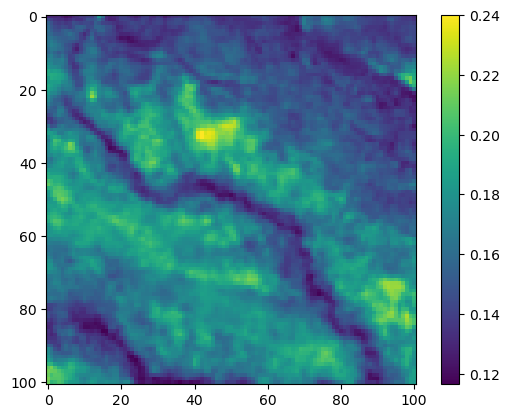

In [43]:
for i in range(0, 1):
    plt.imshow(b12_tens[i].numpy())
    plt.colorbar()
    plt.show()

## View as RGB

Given the Red (B4), Green (B3), and Blue (B2) bands, we can create an RGB image.

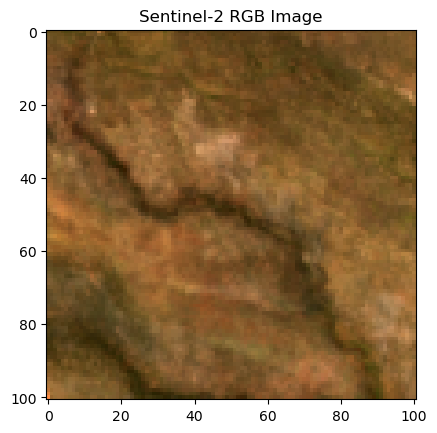

In [44]:
# Assuming b4_tens, b3_tens, and b2_tens are your tensors
rgb_image = torch.stack([b4_tens, b3_tens, b2_tens], dim=-1)

# Convert to NumPy
rgb_image_np = rgb_image[0].cpu().numpy()

# Normalize to the range [0, 1] for display
rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

# Display the image
plt.imshow(rgb_image_np)
plt.title('Sentinel-2 RGB Image')
plt.show()

## Presence records - target of model

The target is what we are trying to predict with the deepSSF model, with is the location of the observed next step.

In [45]:
# Using rasterio
with rasterio.open(pres_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)
print(type(pres_stack))

(10103, 101, 101)
<class 'numpy.ndarray'>


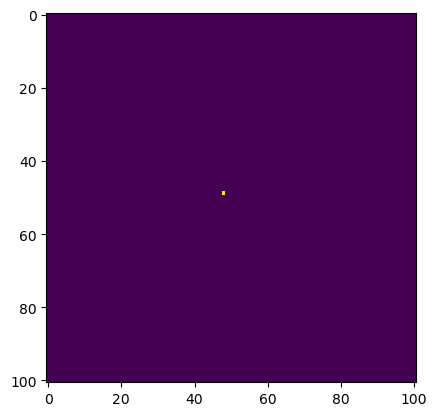

In [46]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [47]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


### Combine the spatial layers into channels

In [48]:
# use sentinel-2 bands
combined_stack = torch.stack([b1_tens, 
                              b2_tens, 
                              b3_tens, 
                              b4_tens,
                              b5_tens, 
                              b6_tens, 
                              b7_tens, 
                              b8_tens,
                              b8a_tens, 
                              b9_tens, 
                              b11_tens, 
                              b12_tens,
                              slope_tens], 
                              dim=1)

print(combined_stack.shape)

torch.Size([10103, 13, 101, 101])


## Defining data sets and data loaders

### Creating a dataset class

This custom PyTorch Dataset organizes all your input (spatial data, scalar covariates, bearing, and target) in a single object, allowing you to neatly manage how samples are accessed. The `__init__` method prepares and stores all the data, `__len__` returns the total number of samples, and `__getitem__` retrieves a single sample by index—enabling straightforward batching and iteration when used with a DataLoader.

In [49]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to grid data and added to the spatial covariates for CNN components
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 
                                                                'hour_t2_cos', 
                                                                'yday_t2_sin', 
                                                                'yday_t2_cos']].values).float()

       # the bearing data that will be added as a channel to the spatial covariates
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()

        # the target data
        self.target = torch.tensor(pres_stack)

        # number of samples
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # allows for the use of len() function
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]

Now we can create an instance of the dataset class and check that is working as expected.

In [50]:
# Create an instance of our custom buffalo_data Dataset:
dataset = buffalo_data()

# Print the total number of samples loaded (determined by n_samples in the dataset):
print(dataset.n_samples)

# Retrieve *all* samples (using the slice dataset[:] invokes __getitem__ on all indices).
# This returns a tuple of (spatial data, scalar-to-grid data, bearing data, target labels).
features1, features2, features3, labels = dataset[:]

# Examine the dimensions of each returned tensor for verification:

# Spatial data
print(features1.shape)

# Scalar-to-grid data
print(features2.shape)

# Bearing data
print(features3.shape)

# Target labels
print(labels.shape)

10103
torch.Size([10103, 13, 101, 101])
torch.Size([10103, 4])
torch.Size([10103, 1])
torch.Size([10103, 101, 101])


### Split into training, validation and test sets

In [51]:
training_split = 0.8 # 80% of the data will be used for training
validation_split = 0.1 # 10% of the data will be used for validation (deciding when to stop training)
test_split = 0.1 # 10% of the data will be used for testing (model evaluation)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, 
                                                                         [training_split, 
                                                                          validation_split, 
                                                                          test_split])
print("Number of training samples: ", len(dataset_train))
print("Number of validation samples: ", len(dataset_val))
print("Number of testing samples: ", len(dataset_test))

Number of training samples:  8083
Number of validation samples:  1010
Number of testing samples:  1010


### Create dataloaders

The DataLoader in PyTorch wraps an iterable around the Dataset to enable easy access to the samples.

In [52]:
# Define the batch size for how many samples to process at once in each step:
bs = 32

# Create a DataLoader for the training dataset with a batch size of bs, and shuffle samples 
# so that the model doesn't see data in the same order each epoch.
dataloader_train = DataLoader(dataset=dataset_train, 
                              batch_size=bs, 
                              shuffle=True)

# Create a DataLoader for the validation dataset, also with a batch size of bs and shuffling.
# Even though it's not always mandatory to shuffle validation data, some users keep the same setting.
dataloader_val = DataLoader(dataset=dataset_val, 
                            batch_size=bs, 
                            shuffle=True)

# Create a DataLoader for the test dataset, likewise with a batch size of bs and shuffling.
# As we want to index the testing data for plotting, we will not shuffle the test data.
dataloader_test = DataLoader(dataset=dataset_test, 
                             batch_size=bs, 
                             shuffle=True)

Check that the data loader is working as expected.

In [53]:
# Display image and label.
# next(iter(dataloader_train)) returns the next batch of the training data
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 13, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Load the model

As we have already described the model in detail in the `deepSSF_model` script, we can simply import the model here.

We will use the same model architecture as in the previous script, except that we will need to use a slightly edited dictionary to account for the additional input channels.

In [54]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [55]:
# In our case the 12 Sentinel-2 layers + slope
num_spatial_covs = 13 

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

## Instantiate the model

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [56]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128,

## Set model hyperparameters

Set the learning rate, loss function, optimizer, scheduler and early stopping. 

In [57]:
learning_rate = 1e-3

# Define the negative log-likelihood loss function with mean reduction
loss_fn = deepSSF_loss.negativeLogLikeLoss(reduction='mean')

# path to save the model weights
path_save_weights = f'model_checkpoints/deepSSF_S2_slope_buffalo{buffalo_id}_{today_date}.pt'

# Set up the Adam optimizer for updating the model's parameters
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# Create a learning rate scheduler that reduces the LR by a factor of 0.1 
#    if validation loss has not improved for 'patience=5' epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,  # The optimizer whose learning rate will be adjusted
    mode='min', # The metric to be minimized (e.g., validation loss)
    factor=0.1, # Factor by which the learning rate will be reduced
    patience=5  # Number of epochs with no improvement before learning rate reduces
)

# EarlyStopping stops training after 'patience=10' epochs with no improvement, 
#    optionally saving the best model weights
early_stopping = deepSSF_early_stopping.EarlyStopping(patience=20, verbose=True, path=path_save_weights)

## Training loop

This code defines the main training loop for a single epoch. It iterates over batches from the training dataloader, moves the data to the correct device (e.g., CPU or GPU), calculates the loss, and performs backpropagation to update the model parameters. It also prints periodic updates of the current loss.

In [58]:
def train_loop(dataloader_train, model, loss_fn, optimiser):
    """
    Runs the training process for one epoch using the given dataloader, model, 
    loss function, and optimizer. Prints progress updates every few batches.
    """

    # 1. Total number of training examples
    size = len(dataloader_train.dataset)

    # 2. Put model in training mode (affects layers like dropout, batchnorm)
    model.train()

    # 3. Variable to accumulate the total loss over the epoch
    epoch_loss = 0.0

    # 4. Loop over batches in the training dataloader
    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):

        # Move the batch of data to the specified device (CPU/GPU)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        y = y.to(device)

        # Forward pass: compute the model output and loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation: compute gradients and update parameters
        loss.backward()
        optimiser.step()

        # Reset gradients before the next iteration
        optimiser.zero_grad()

        # Print an update every 5 batches to keep track of training progress
        if batch % 5 == 0:
            loss_val = loss.item()
            current = batch * bs + len(x1)
            print(f"loss: {loss_val:>15f}  [{current:>5d}/{size:>5d}]")

## Test loop

The test loop is similar to the training loop, but it does not perform backpropagation. It calculates the loss on the test set and returns the average loss.

In [59]:
def test_loop(dataloader_test, model, loss_fn):
    """
    Evaluates the model on the provided test dataset by computing 
    the average loss over all batches. 
    No gradients are computed during this process (torch.no_grad()).
    """

    # 1. Set the model to evaluation mode (affects layers like dropout, batchnorm).
    model.eval()

    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    
    test_loss = 0

    # 2. Disable gradient computation to speed up evaluation and reduce memory usage
    with torch.no_grad():
        # 3. Loop through each batch in the test dataloader
        for x1, x2, x3, y in dataloader_test:

            # Move the batch of data to the appropriate device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Compute the loss on the test set (no backward pass needed)
            test_loss += loss_fn(model((x1, x2, x3)), y)

    # 4. Compute average test loss over all batches
    test_loss /= num_batches

    # Print the average test loss
    print(f"Avg test loss: {test_loss:>15f} \n")

## Train the model

In [60]:
epochs = 100
val_losses = []   # Track validation losses across epochs

for t in range(epochs):
    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")

    # 1. Run the training loop for one epoch using the training dataloader
    train_loop(dataloader_train, model, loss_fn, optimiser)

    # 2. Evaluate model performance on the validation dataset
    model.eval()  # Switch to evaluation mode for proper layer behavior
    with torch.no_grad():
        
        for x1, x2, x3, y in dataloader_val:
            # Move data to the chosen device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Accumulate validation loss
            val_loss += loss_fn(model((x1, x2, x3)), y)

    # 3. Step the scheduler based on the validation loss (adjusts learning rate if needed)
    scheduler.step(val_loss)

    # 4. Compute the average validation loss and print it, along with the current learning rate
    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")

    # 5. Track the validation loss for plotting or monitoring
    val_losses.append(val_loss)

    # 6. Early stopping: if no improvement in validation loss for a set patience, stop training
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        # Restore the best model weights saved by EarlyStopping
        model.load_state_dict(torch.load(path_save_weights, weights_only=True))
        test_loop(dataloader_test, model, loss_fn)  # Evaluate on test set once training stops
        break
    else:
        model.eval()
        print("\n")

print("Done!")

Epoch 1
-------------------------------
loss:        0.000820  [   32/ 8083]
loss:        0.000711  [  192/ 8083]
loss:        0.000606  [  352/ 8083]
loss:        0.000546  [  512/ 8083]
loss:        0.000617  [  672/ 8083]
loss:        0.000587  [  832/ 8083]
loss:        0.000603  [  992/ 8083]
loss:        0.000676  [ 1152/ 8083]
loss:        0.000518  [ 1312/ 8083]
loss:        0.000564  [ 1472/ 8083]
loss:        0.000654  [ 1632/ 8083]
loss:        0.000506  [ 1792/ 8083]
loss:        0.000603  [ 1952/ 8083]
loss:        0.000650  [ 2112/ 8083]
loss:        0.000649  [ 2272/ 8083]
loss:        0.000556  [ 2432/ 8083]
loss:        0.000539  [ 2592/ 8083]
loss:        0.000555  [ 2752/ 8083]
loss:        0.000558  [ 2912/ 8083]
loss:        0.000582  [ 3072/ 8083]
loss:        0.000570  [ 3232/ 8083]
loss:        0.000524  [ 3392/ 8083]
loss:        0.000517  [ 3552/ 8083]
loss:        0.000587  [ 3712/ 8083]
loss:        0.000572  [ 3872/ 8083]
loss:        0.000633  [ 4032/ 8083

### Create an output directory to save the outputs and plots.

In [61]:
# To save the outputs of the model, create a directory
output_dir = f'outputs/model_outputs/deepSSF_S2/id{buffalo_id}'
os.makedirs(output_dir, exist_ok=True)

### Save the validation loss as a dataframe

In [62]:
# Directory for saving the loss dataframe
filename_loss_csv = f'{output_dir}/deepSSF_S2_val_loss_buffalo{buffalo_id}_{today_date}.csv'

val_losses_df = pd.DataFrame({
    "epoch": range(1, len(val_losses) + 1),
    "val_losses": val_losses
})

# Save the validation losses to a CSV file
val_losses_df.to_csv(filename_loss_csv, index=False)

### Plot the validation loss

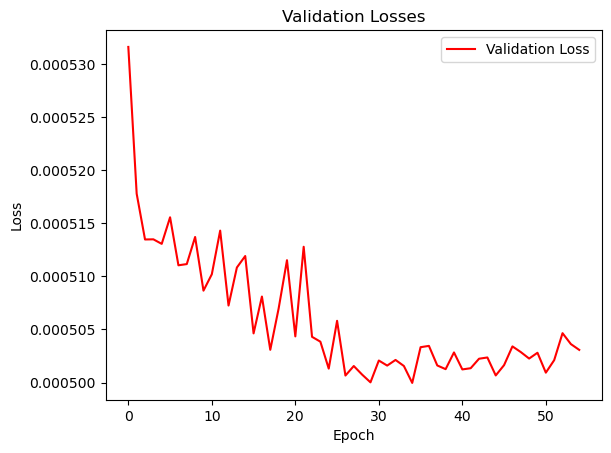

In [63]:
# Directory for saving the loss plots
filename_loss_png = f'{output_dir}/deepSSF_S2_val_loss_buffalo{buffalo_id}_{today_date}.png'

# Plot the validation losses
plt.plot(val_losses, label='Validation Loss', color='red')  # Plot validation loss in red
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend to distinguish lines
plt.savefig(filename_loss_png, dpi=600, bbox_inches='tight')
plt.show()

### Check model parameters

In [64]:
# to look at the parameters (weights and biases) of the model
# print(model.state_dict())

# Loading in previous models

As we've trained the model, the model parameters are already stored in the `model` object. But as we were training the model, we were saving it to file, and that, and other trained models can be loaded. 

The model parameters that are being loaded must match the model object that has been defined above. If the model object has changed, the model parameters will not be able to be loaded.

In [65]:
path_save_weights

'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt'

### If loading a previously trained model

In [66]:
# to load previously saved weights
# path_save_weights = f'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt'

model.load_state_dict(torch.load(path_save_weights, 
                                 weights_only=True,
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

# Test model

Take some random samples from the test dataset and generate predictions for them. We loop through the samples (which are shuffled randomly), make predictions, and plot the results.

### Helper functions

To return the hour and day of the year to their original values, we can use the following functions.

In [67]:
def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

Hour:                        8
Day of the year:             175
Bearing (radians):           2.2515599727630615
Bearing (degrees):           129
Next step is (row, column):  (52, 45)


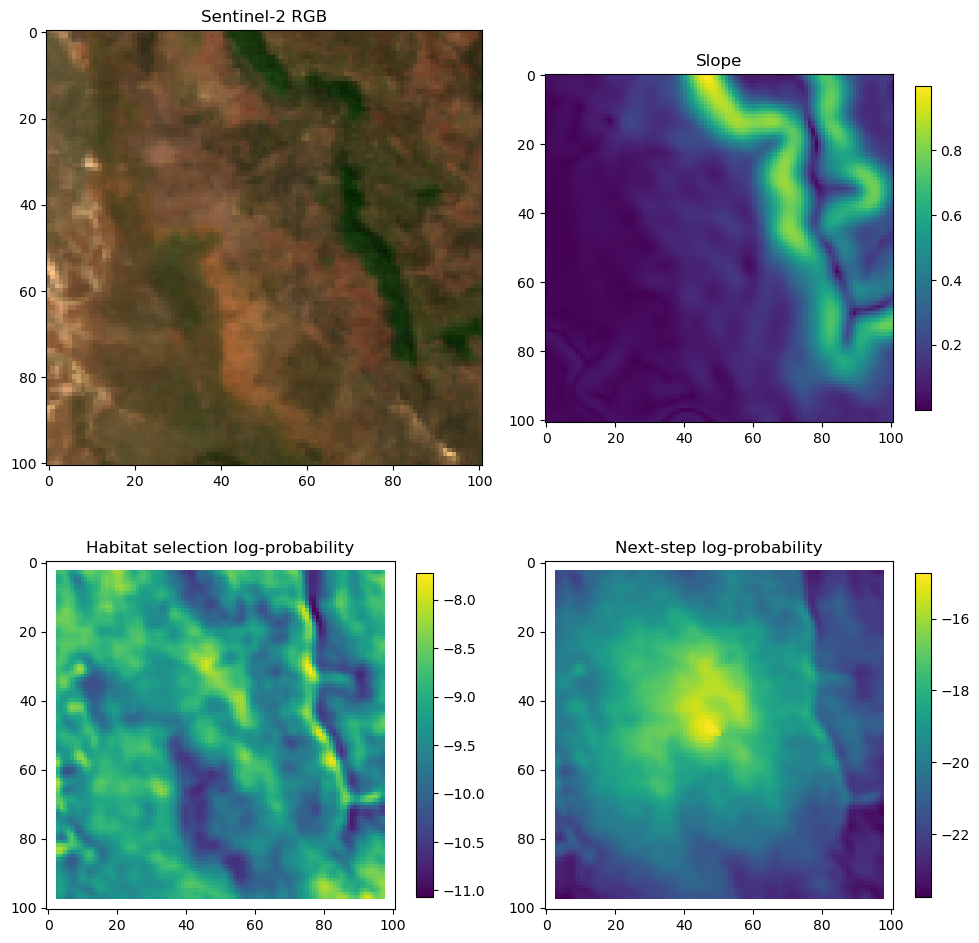

Hour:                        17
Day of the year:             217
Bearing (radians):           -0.1754153072834015
Bearing (degrees):           349
Next step is (row, column):  (48, 50)


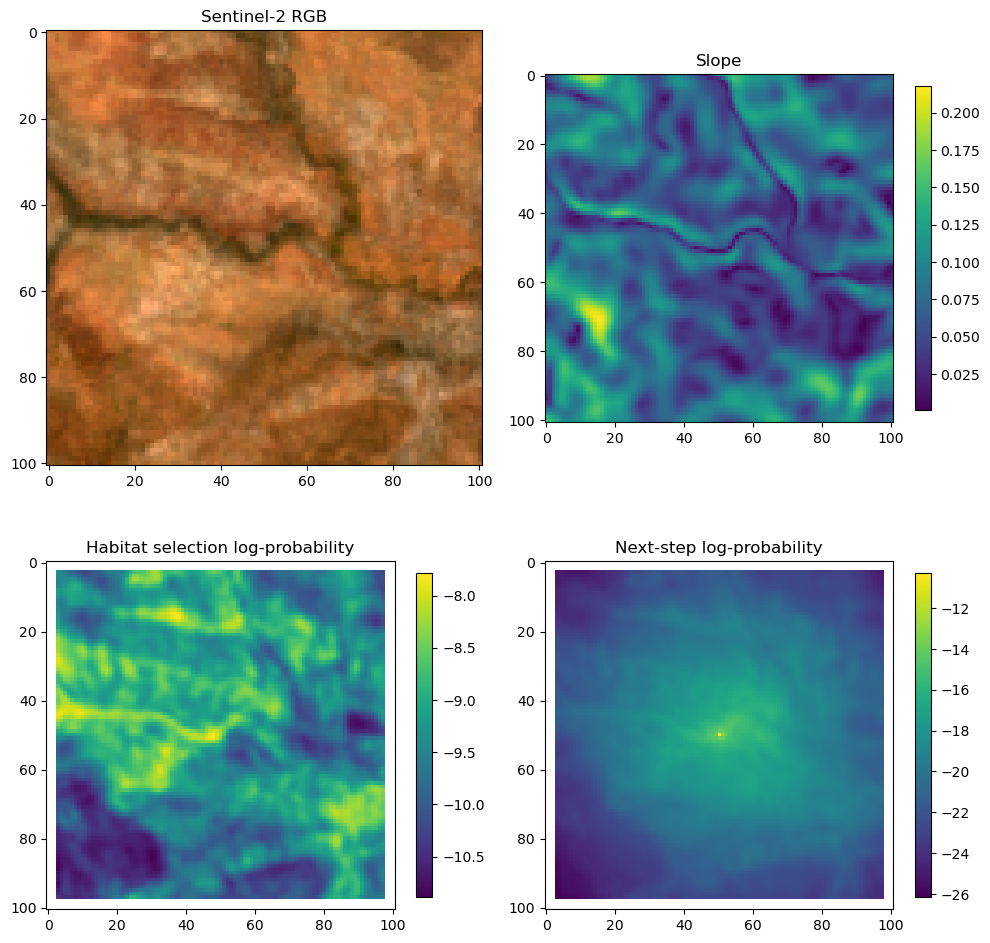

Hour:                        3
Day of the year:             9
Bearing (radians):           -1.8308851718902588
Bearing (degrees):           255
Next step is (row, column):  (50, 50)


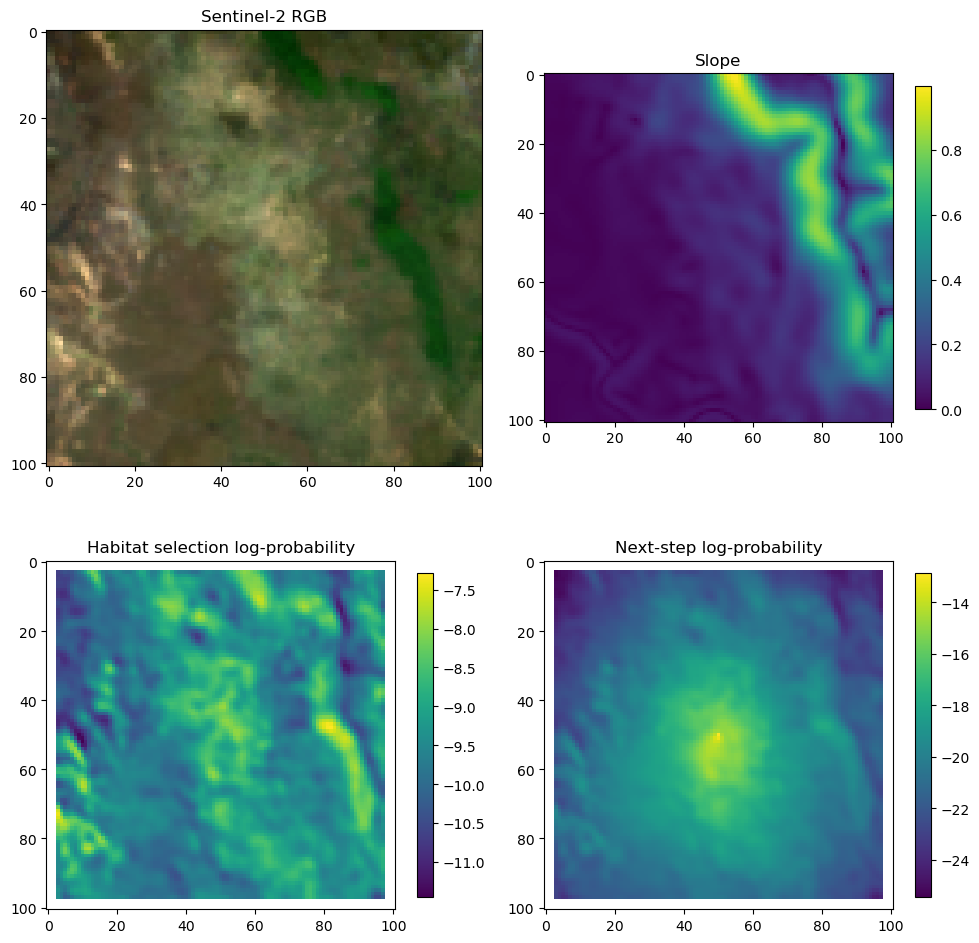

Hour:                        10
Day of the year:             224
Bearing (radians):           2.1292378902435303
Bearing (degrees):           122
Next step is (row, column):  (49, 62)


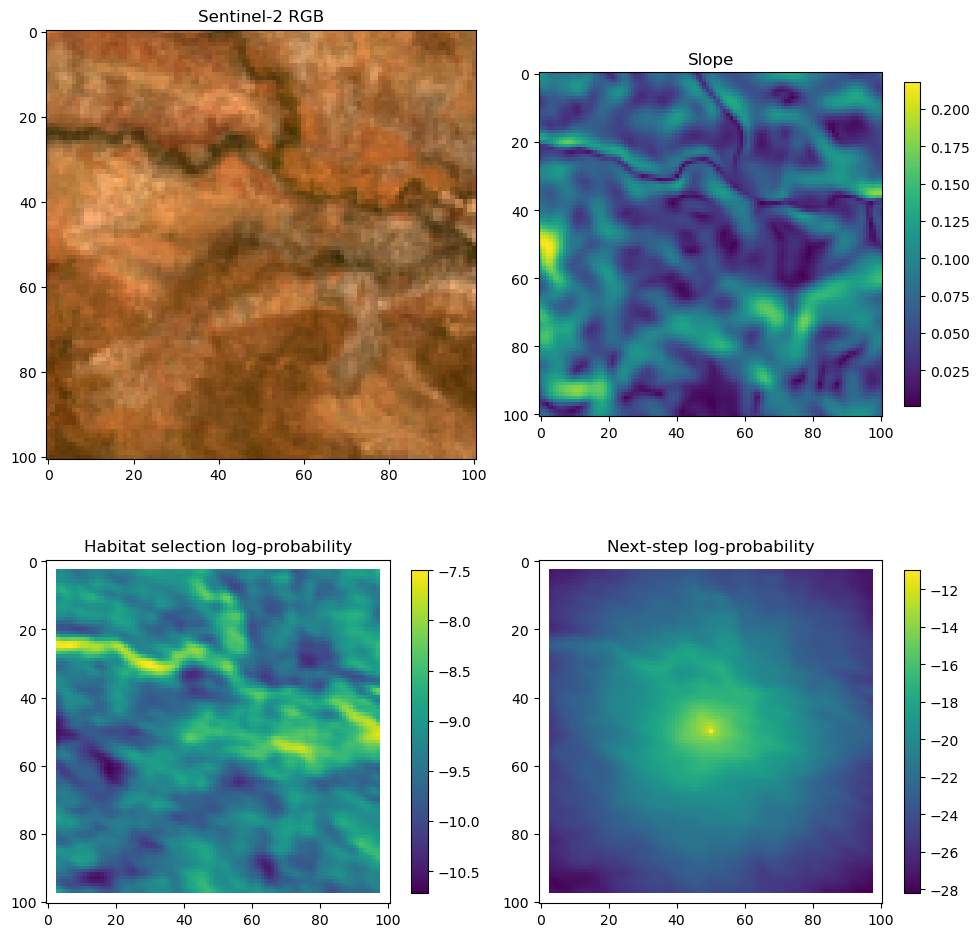

Hour:                        14
Day of the year:             7
Bearing (radians):           2.781324625015259
Bearing (degrees):           159
Next step is (row, column):  (49, 50)


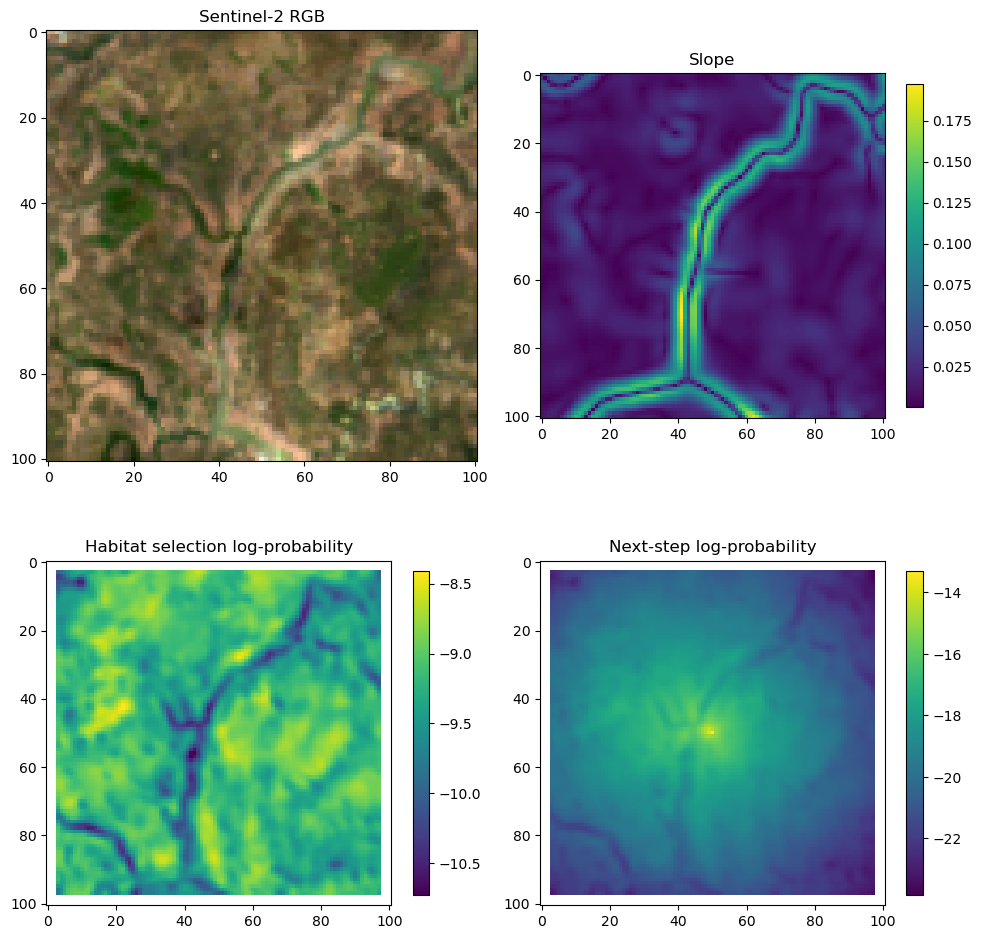

In [68]:
# 1. Set the model in evaluation mode
model.eval()

# Loop over samples in the validation dataset
for i in range(0, 5):

  # Display image and label
  x1, x2, x3, labels = next(iter(dataloader_test))

  # Pull out the scalars
  hour_t2_sin = x2.detach().numpy()[0,0]
  hour_t2_cos = x2.detach().numpy()[0,1]
  yday_t2_sin = x2.detach().numpy()[0,2]
  yday_t2_cos = x2.detach().numpy()[0,3]
  bearing = x3.detach().numpy()[0,0]

  # Recover the hour
  hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
  hour_t2_integer = int(hour_t2)  # Convert to integer
  print(f'Hour:                        {hour_t2_integer}')

  # Recover the day of the year
  yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
  yday_t2_integer = int(yday_t2)  # Convert to integer
  print(f'Day of the year:             {yday_t2_integer}')

  # Recover the bearing
  bearing_degrees = np.degrees(bearing) % 360
  bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
  bearing_degrees = int(bearing_degrees)  # Convert to integer
  print(f'Bearing (radians):           {bearing}')
  print(f'Bearing (degrees):           {bearing_degrees}')

  # Pull out the RGB layers for plotting
  blue_layer = x1.detach().cpu().numpy()[0,1,:,:]
  green_layer = x1.detach().cpu().numpy()[0,2,:,:]
  red_layer = x1.detach().cpu().numpy()[0,3,:,:]

  # Stack the RGB layers
  rgb_image_np = np.stack([red_layer, green_layer, blue_layer], axis=-1)

  # Normalize to the range [0, 1] for display
  rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

  # Find the coordinates of the element that is 1
  target = labels.detach().cpu().numpy()[0,:,:]
  coordinates = np.where(target == 1)

  # Extract the coordinates
  row, column = coordinates[0][0], coordinates[1][0]
  print(f"Next step is (row, column):  ({row}, {column})")


  # -------------------------------------------------------------------------
  # Run the model on the input data
  # -------------------------------------------------------------------------

  # Move input tensors to the GPU if available
  x1 = x1.to(device)
  x2 = x2.to(device)
  x3 = x3.to(device)

  test = model((x1, x2, x3))
  # print(test.shape)

  # Extract and exponentiate the habitat density channel
  hab_density = test.detach().cpu().numpy()[0, :, :, 0]
  hab_density_exp = np.exp(hab_density)
  # print(np.sum(hab_density_exp))  # Debug: check the sum of exponentiated values

  # Create masks to remove unwanted edge cells from visualization
  #    (setting them to -∞ affects the color scale in plots)
  x_mask = np.ones_like(hab_density)
  y_mask = np.ones_like(hab_density)

  # mask out cells on the edges that affect the colour scale
  x_mask[:, :3] = -np.inf
  x_mask[:, 98:] = -np.inf
  y_mask[:3, :] = -np.inf
  y_mask[98:, :] = -np.inf

  # Apply the masks to the habitat density (log scale) and exponentiated version
  hab_density_mask = hab_density * x_mask * y_mask
  hab_density_exp_mask = hab_density_exp * x_mask * y_mask

  # Extract and exponentiate the movement density channel
  move_density = test.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)

  # Apply the same masking strategy to movement densities
  move_density_mask = move_density * x_mask * y_mask
  move_density_exp_mask = move_density_exp * x_mask * y_mask

  # Compute the next-step density by adding habitat + movement (log-space)
  step_density = test[0, :, :, 0] + test[0, :, :, 1]
  step_density = step_density.detach().cpu().numpy()
  step_density_exp = np.exp(step_density)

  # Apply masks to the step densities (log and exponentiated)
  step_density_mask = step_density * x_mask * y_mask
  step_density_exp_mask = step_density_exp * x_mask * y_mask

  # -------------------------------------------------------------------------
  # Plot the RGB image, slope, habitat selection, and movement density
  #   Change the panels to visualize different layers
  # -------------------------------------------------------------------------
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  # Plot RGB
  im1 = axs[0, 0].imshow(rgb_image_np)
  axs[0, 0].set_title('Sentinel-2 RGB')

  # Plot slope
  im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
  axs[0, 1].set_title('Slope')
  fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # Plot habitat selection
  im3 = axs[1, 0].imshow(hab_density_mask, cmap='viridis')
  axs[1, 0].set_title('Habitat selection log-probability')
  fig.colorbar(im3, ax=axs[1, 0], shrink=0.7)

  # # Movement density (change the axis and uncomment one of the other panels)
  # im3 = axs[1, 0].imshow(move_density_mask, cmap='viridis')
  # axs[1, 0].set_title('Movement log-probability')
  # fig.colorbar(im3, ax=axs[0, 1], shrink=0.7)

  # Next-step probability
  im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
  axs[1, 1].set_title('Next-step log-probability')
  fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

  #
  filename_covs = f'{output_dir}/deepSSF_S2_slope_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
  plt.tight_layout()
  plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
  plt.show()
  plt.close()  # Close the figure to free memory


# Extracting convolution layer outputs

In the convolutional blocks, each convolutional layer learns a set of **filters** (kernels) that extract different features from the input data. In the habitat selection subnetwork, the convolution filters (and their associated bias parameters - not shown below) are the only parameters that are trained, and it is the filters that transform the set of input covariates into the habitat selection probabilities. They do this by maximising features of the inputs that correlate with observed next-steps.

For each convolutional layer, there are typically a number of filters. For the habitat selection subnetwork, we used 4 filters in the first two layers, and a single filter in the last layer. Each of these filters has a number of **channels** which correspond one-to-one with the input layers. The outputs of the filter channels are then combined to produce a feature map, with a single feature map produced for each filter. In successive layers, the feature maps become the input layers, and the filters operate on these layers. Because there are multiple filters in ech layer, they can 'specialise' in extracting different features from the input layers.

By visualizing and inspecting these filters, and the corresponding feature maps, we can:

- Gain interpretability: Understand what kind of features the network is detecting—e.g., edges, shapes, or textures.
- Debug: Check if the filters have meaningful patterns or if something went wrong (e.g., all zeros or random noise).
- Compare layers: See how early layers often learn low-level patterns while deeper layers learn more abstract features.

We will first set up some activation hooks for storing the feature maps. Activation hooks are placed at certain points within the model's forward pass and store intermediate results. We will also extract the convolution filters (which are weights of the model and as such don't require hooks - we can access them directly).

We will then run the sample covariates through the model and extract the feature maps from the habitat selection convolutional block, and plot them along with the covariates and convolution filters.

Note that there are also ReLU activation functions in the convolutional blocks, which are not shown below. These are applied to the feature maps, and set all negative values to zero. They are not learned parameters, but are part of the forward pass of the model.


### Create scalar grids for plotting

Using the `Scalar_to_Grid_Block` class from the `deepSSF_model` script, we can convert the scalar covariates into grids for plotting.

In [69]:
# Create an instance of the scalar-to-grid block using model parameters
scalar_to_grid_block = deepSSF_model.Scalar_to_Grid_Block(params)

# Convert scalars into spatial grid representation
scalar_maps = scalar_to_grid_block(x2)
print(scalar_maps.shape)  # Check the shape of the generated spatial maps

torch.Size([32, 4, 101, 101])


## Convolutional layer 1

### Activation hook

In [70]:
# -----------------------------------------------------------
# Create a dictionary to store activation outputs
# -----------------------------------------------------------
activation = {}

def get_activation(name):
    """
    Returns a hook function that can be registered on a layer 
    to capture its output (i.e., feature maps) after the forward pass.

    Args:
        name (str): The key under which the activation is stored in the 'activation' dict.
    """
    def hook(model, input, output):
        # Detach and save the layer's output in the dictionary
        activation[name] = output.detach()
    return hook

# -----------------------------------------------------------
# Register a forward hook on the first convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[0].register_forward_hook(get_activation("hab_conv1"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps1 = activation["hab_conv1"].cpu()
print("Feature map shape:", feat_maps1.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps1_sample = feat_maps1[0]  # Shape: (out_channels, H, W)
num_maps1 = feat_maps1_sample.shape[0]
print("Number of feature maps:", num_maps1)



Feature map shape: torch.Size([32, 4, 101, 101])
Number of feature maps: 4


### Stack spatial and scalar (as grid) covariates

For plotting. Also create a vector of names to index over.

In [71]:
covariate_stack = torch.cat([x1, scalar_maps], dim=1)
print(covariate_stack.shape)

covariate_names = ['S2 B1',
                   'S2 B2',
                   'S2 B3',
                   'S2 B4',
                   'S2 B5',
                   'S2 B6',
                   'S2 B7',
                   'S2 B8',
                   'S2 B8a',
                   'S2 B9',
                   'S2 B11',
                   'S2 B12',
                   'Slope', 
                   'Hour sin', 
                   'Hour cos', 
                   'yday sin', 
                   'yday cos']

torch.Size([32, 17, 101, 101])


### Extract filters and plot

Sequential(
  (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Filters shape: torch.Size([4, 17, 3, 3])
17


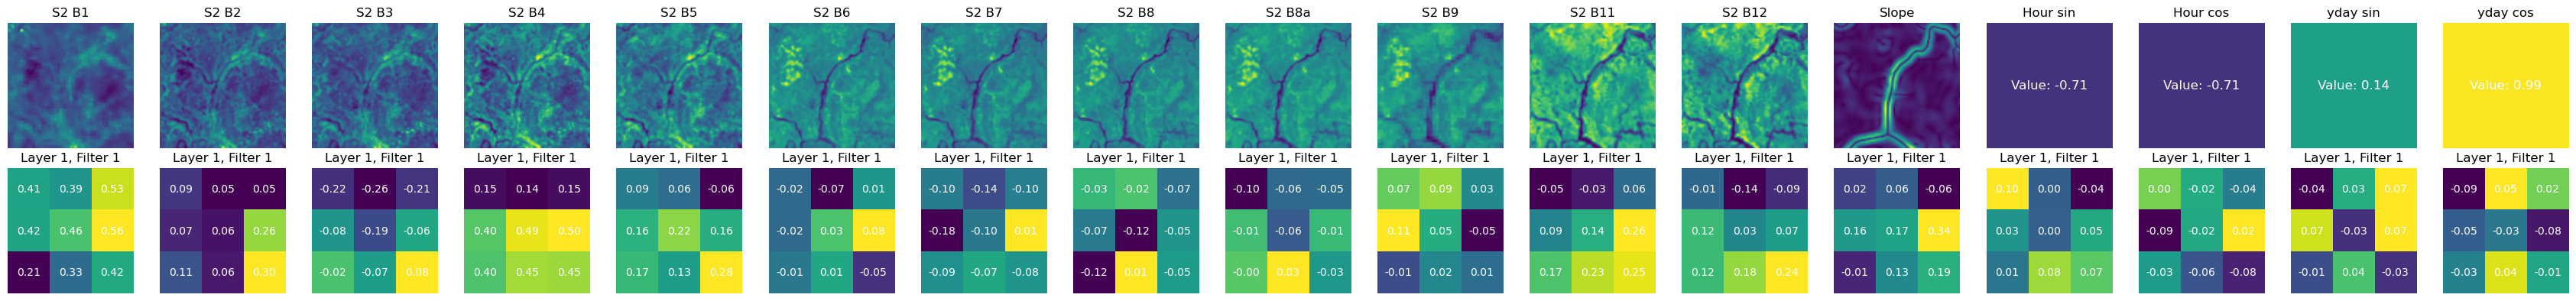

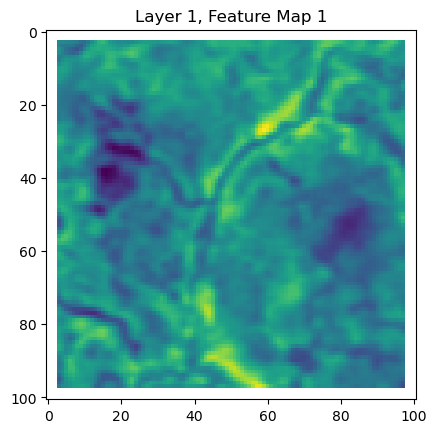

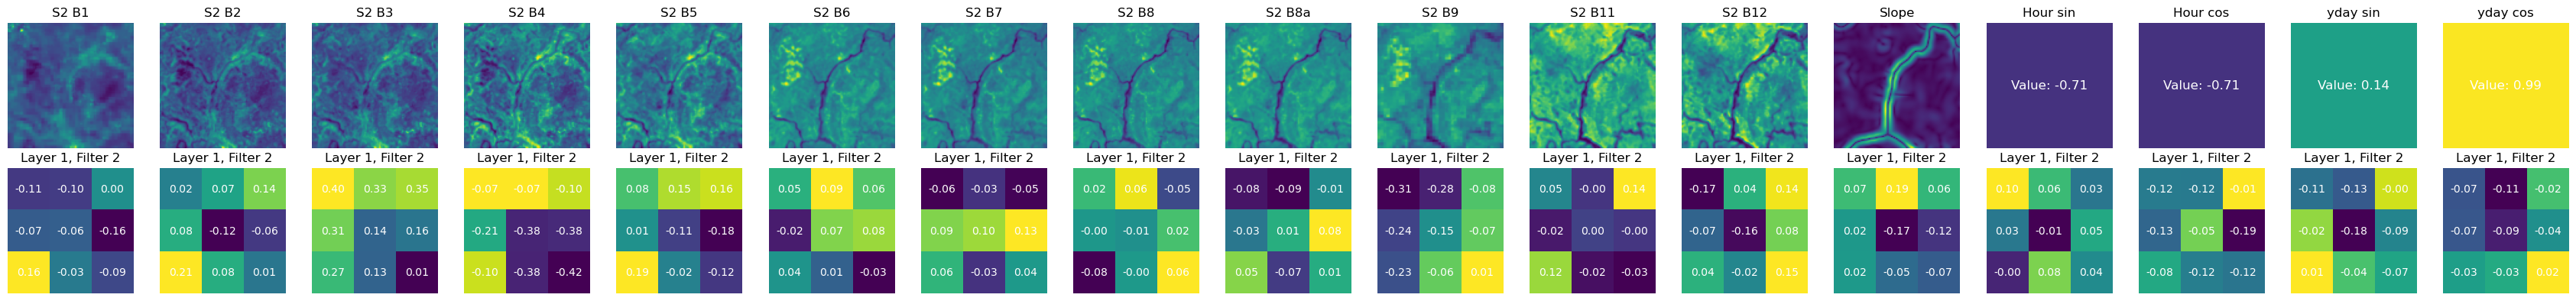

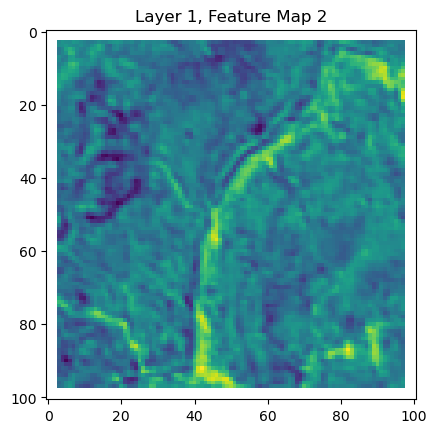

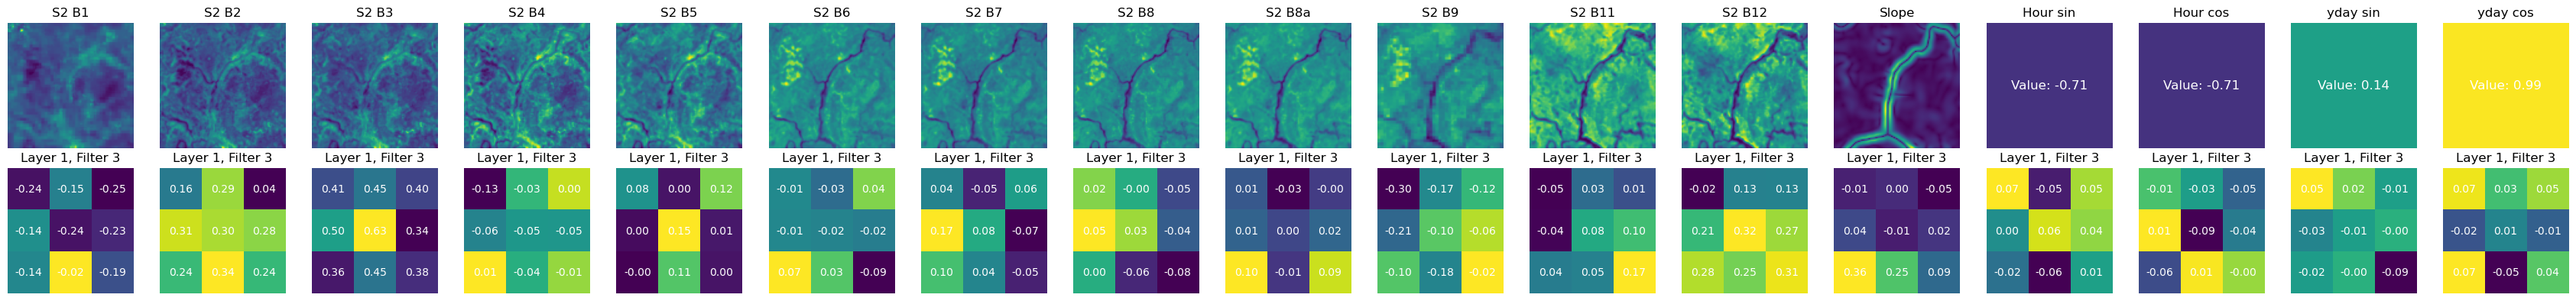

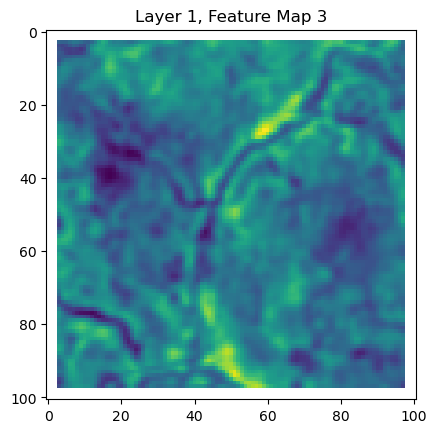

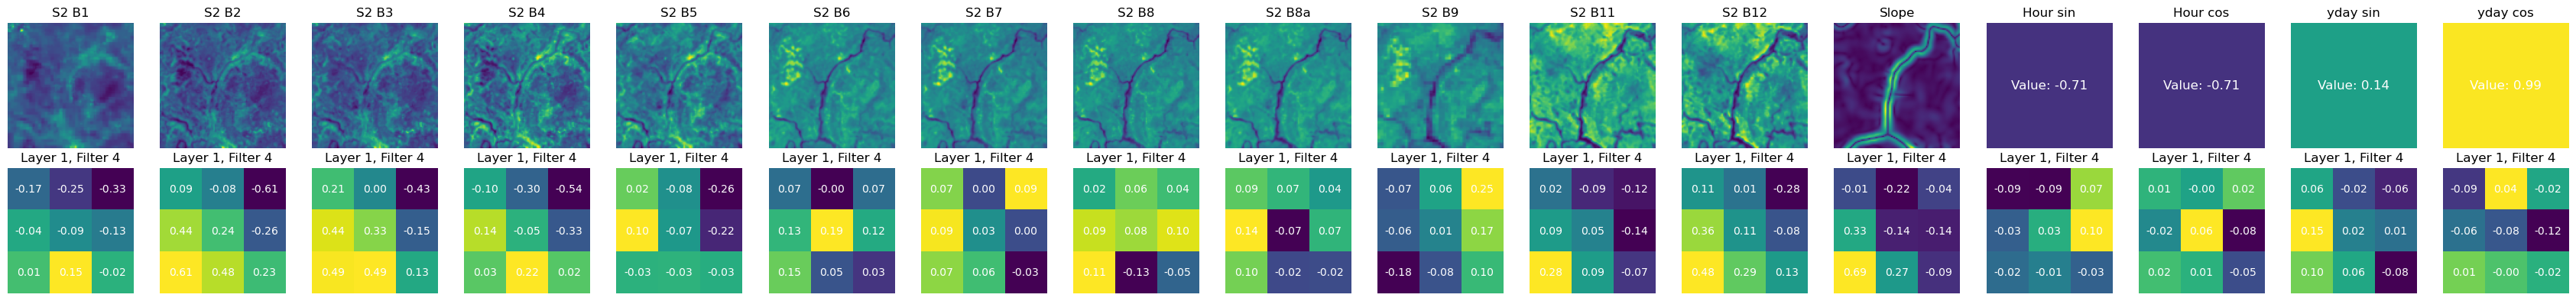

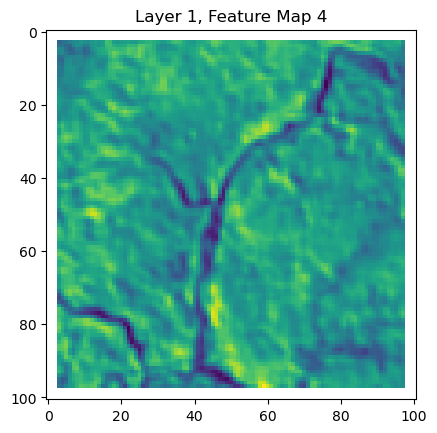

In [72]:
# -------------------------------------------------------------------------
# Check or print the convolution layer in conv_habitat (for debugging)
# -------------------------------------------------------------------------
print(model.conv_habitat.conv2d)

# -------------------------------------------------------------------------
# Set the model to evaluation mode (disables dropout, etc.)
# -------------------------------------------------------------------------
model.eval()

# -------------------------------------------------------------------------
# Extract the weights (filters) from the first convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c1 = model.conv_habitat.conv2d[0].weight.data.clone().cpu()
print("Filters shape:", filters_c1.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c1 = filters_c1.shape[1]
print(num_filters_c1)

for z in range(num_maps1):

    fig, axes = plt.subplots(2, num_filters_c1, figsize=(2*num_filters_c1, 4))
    for i in range(num_filters_c1):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f'{covariate_names[i]}')
        if i > x1.shape[1] - 1:
            im1 = axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
            im1.set_clim(-1, 1)
            axes[0,i].text(scalar_maps.shape[2] // 2, scalar_maps.shape[3] // 2, 
                f'Value: {round(x2[0, i-x1.shape[1]].item(), 2)}', 
                ha='center', va='center', color='white', fontsize=12)

        kernel = filters_c1[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 1, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer1_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps1_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Layer 1, Feature Map {z+1}")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer1_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



## Convolutional layer 2

### Activation hook

In [73]:
# -----------------------------------------------------------
# Register a forward hook on the second convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[2].register_forward_hook(get_activation("hab_conv2"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps2 = activation["hab_conv2"].cpu()
print("Feature map shape:", feat_maps2.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps2_sample = feat_maps2[0]  # Shape: (out_channels, H, W)
num_maps2 = feat_maps2_sample.shape[0]
print("Number of feature maps:", num_maps2)



Feature map shape: torch.Size([32, 4, 101, 101])
Number of feature maps: 4


### Extract filters and plot

Filters shape: torch.Size([4, 4, 3, 3])
4


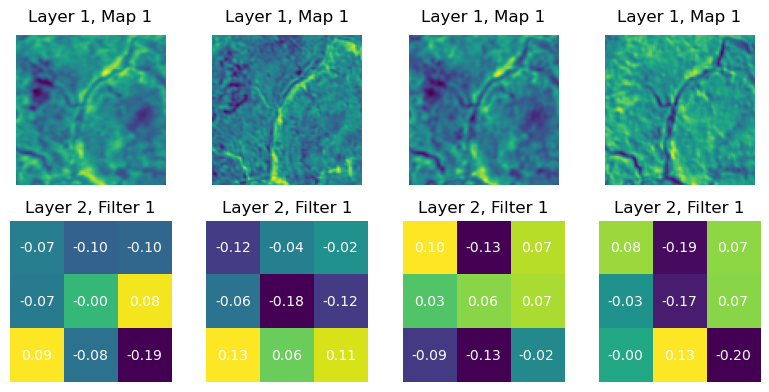

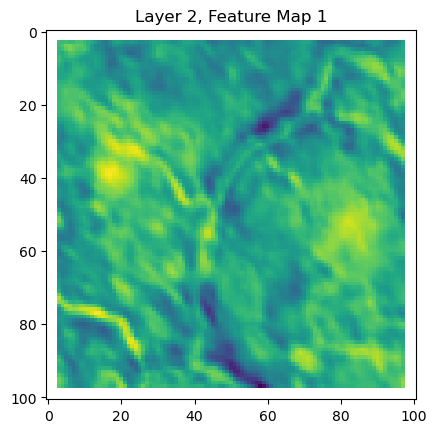

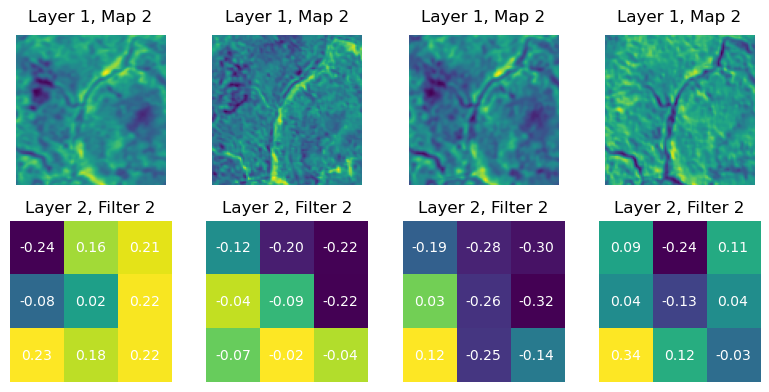

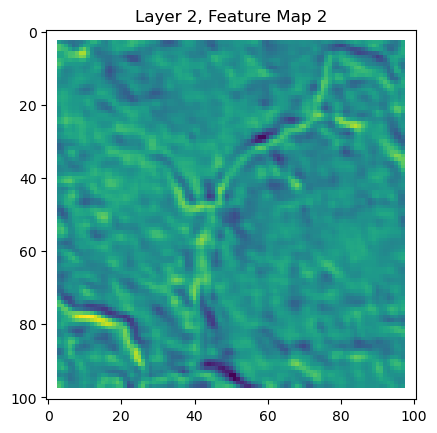

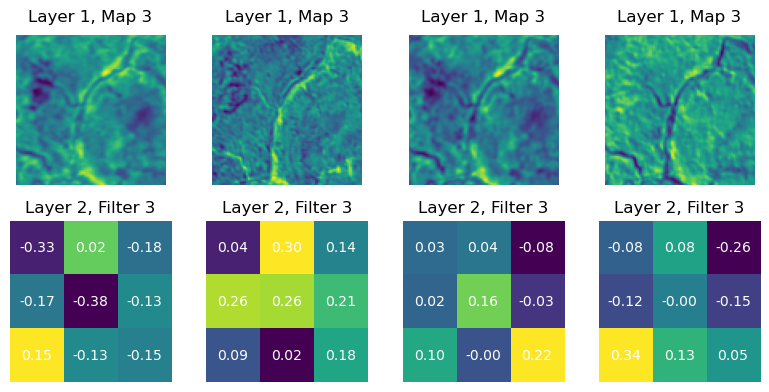

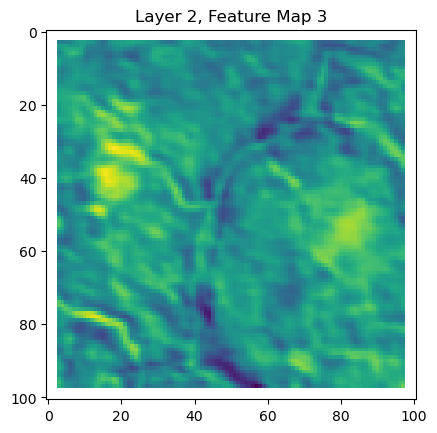

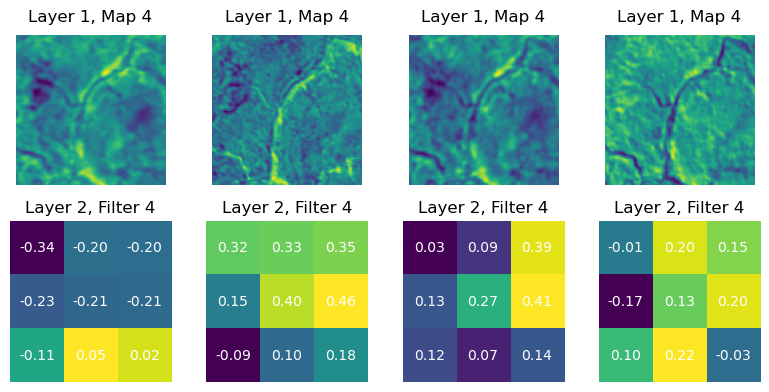

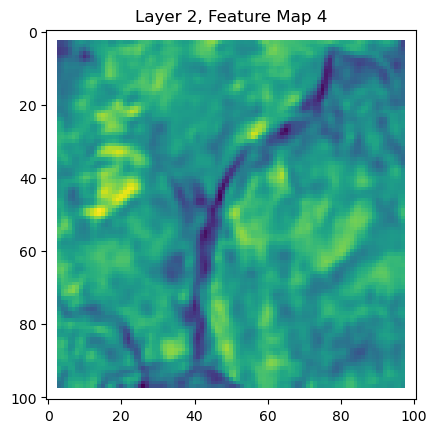

In [74]:
# -------------------------------------------------------------------------
# Extract the weights (filters) from the second convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c2 = model.conv_habitat.conv2d[2].weight.data.clone().cpu()
print("Filters shape:", filters_c2.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c2 = filters_c2.shape[1]
print(num_filters_c2)

for z in range(num_maps2):

    fig, axes = plt.subplots(2, num_filters_c2, figsize=(2*num_filters_c2, 4))
    for i in range(num_filters_c2):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(feat_maps1_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f"Layer 1, Map {z+1}")

        # if i > 3:
        #     im1 = axes[0,i].imshow(covariate_stack[0, i].detach().cpu().numpy(), cmap='viridis')
        #     im1.set_clim(-1, 1)
        #     axes[0,i].text(scalar_maps.shape[2] // 2, scalar_maps.shape[3] // 2, 
        #         f'Value: {round(x2[0, i-4].item(), 2)}', 
        #         ha='center', va='center', color='white', fontsize=12)

        kernel = filters_c2[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 2, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer2_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # 6. Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps2_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Layer 2, Feature Map {z+1}")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer2_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



## Convolutional layer 3

### Activation hook

In [75]:
# -----------------------------------------------------------
# Register a forward hook on the third convolution layer 
#    in the model's 'conv_habitat' block
# -----------------------------------------------------------
model.conv_habitat.conv2d[4].register_forward_hook(get_activation("hab_conv3"))

# -----------------------------------------------------------
# Perform a forward pass through the model with the desired input
#    The feature maps from the hooked layer will be stored in 'activation'
# -----------------------------------------------------------
out = model((x1, x2, x3))  # e.g., model((spatial_data_x, scalars_to_grid, bearing_x))

# -----------------------------------------------------------
# Retrieve the captured feature maps from the dictionary
#    and move them to the CPU for inspection
# -----------------------------------------------------------
feat_maps3 = activation["hab_conv3"].cpu()
print("Feature map shape:", feat_maps3.shape)
# Typically shape: (batch_size, out_channels, height, width)

# -----------------------------------------------------------
# Visualize the feature maps for the first sample in the batch
# -----------------------------------------------------------
feat_maps3_sample = feat_maps3[0]  # Shape: (out_channels, H, W)
num_maps3 = feat_maps3_sample.shape[0]
print("Number of feature maps:", num_maps3)



Feature map shape: torch.Size([32, 1, 101, 101])
Number of feature maps: 1


### Extract filters and plot

Filters shape: torch.Size([1, 4, 3, 3])
4


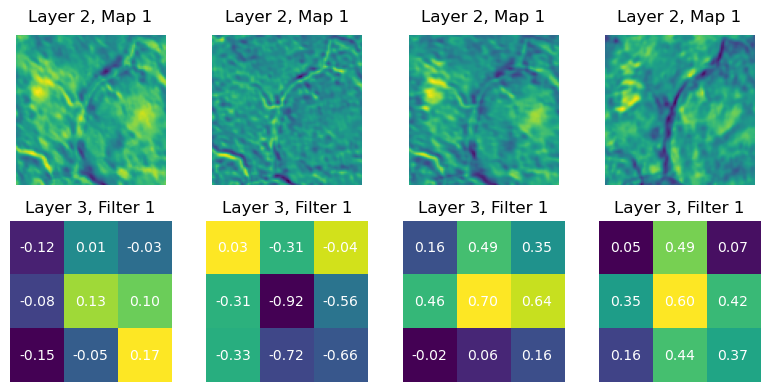

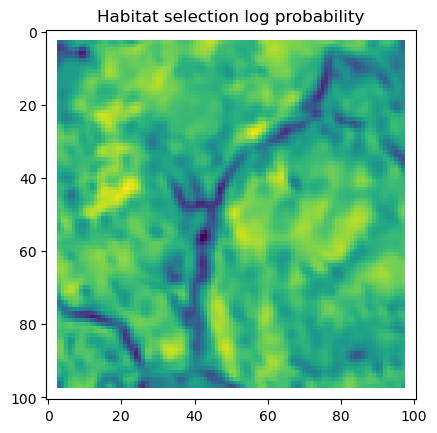

In [76]:
# -------------------------------------------------------------------------
# Extract the weights (filters) from the second convolution layer in conv_habitat
# -------------------------------------------------------------------------
filters_c3 = model.conv_habitat.conv2d[4].weight.data.clone().cpu()
print("Filters shape:", filters_c3.shape)
# Typically (out_channels, in_channels, kernel_height, kernel_width)

# -------------------------------------------------------------------------
# Visualize each filter’s first channel in a grid of subplots
# -------------------------------------------------------------------------
num_filters_c3 = filters_c3.shape[1]
print(num_filters_c3)

for z in range(num_maps3):

    fig, axes = plt.subplots(2, num_filters_c3, figsize=(2*num_filters_c3, 4))
    for i in range(num_filters_c3):

        # Add the covariates as the first row of subplots
        axes[0,i].imshow(feat_maps2_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
        axes[0,i].axis('off')
        axes[0,i].set_title(f"Layer 2, Map {z+1}")


        kernel = filters_c3[z, i, :, :]  # Show the first input channel
        im = axes[1,i].imshow(kernel, cmap='viridis')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Layer 3, Filter {z+1}')
        # Annotate each cell with the numeric value
        for (j, k), val in np.ndenumerate(kernel):
            axes[1,i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer3_filters{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()

        
    # -----------------------------------------------------------
    # 6. Loop over each feature map channel and save them as images.
    #    Multiply by x_mask * y_mask if you need to mask out edges.
    # -----------------------------------------------------------

    plt.figure()
    plt.imshow(feat_maps3_sample[z].numpy() * x_mask * y_mask, cmap='viridis')
    plt.title(f"Habitat selection log probability")
    # Hide axis if you prefer: plt.axis('off')
    plt.savefig(f'{output_dir}/id{buffalo_id}_conv_layer3_feature_map{z}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()



# Checking estimated movement parameters

Similarly to the convolutional layers, we can set hooks to extract the predicted movement parameters from the model, and assess how variable that is across samples.

In [77]:
# -------------------------------------------------------------------------
# Create a list to store the intermediate output from the fully connected
#    movement sub-network (fcn_movement_all)
# -------------------------------------------------------------------------
intermediate_output = []

def hook(module, input, output):
    """
    Hook function that captures the output of the specified layer
    (fcn_movement_all) during the forward pass.
    """
    intermediate_output.append(output)

# -------------------------------------------------------------------------
# Register the forward hook on 'fcn_movement_all', so its outputs
#    are recorded every time the model does a forward pass.
# -------------------------------------------------------------------------
hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# -------------------------------------------------------------------------
# Perform a forward pass with the model in evaluation mode, 
#    disabling gradient computation.
# -------------------------------------------------------------------------
model.eval()
with torch.no_grad():
    final_output = model((x1, x2, x3))

# -------------------------------------------------------------------------
# Inspect the captured intermediate output
#    'intermediate_output[0]' corresponds to the first (and only) forward pass.
# -------------------------------------------------------------------------
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# -------------------------------------------------------------------------
# Remove the hook to avoid repeated capturing in subsequent passes
# -------------------------------------------------------------------------
hook_handle.remove()

# -------------------------------------------------------------------------
# Unpack the parameters from the FCN output (assumes a specific ordering)
# -------------------------------------------------------------------------
gamma_shape1, gamma_scale1, gamma_weight1, \
gamma_shape2, gamma_scale2, gamma_weight2, \
vonmises_mu1, vonmises_kappa1, vonmises_weight1, \
vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]

# -------------------------------------------------------------------------
# Convert parameters from log-space (if applicable) and print them
#    Gamma and von Mises parameters
# -------------------------------------------------------------------------
# --- Gamma #1 ---
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:",
      torch.exp(gamma_weight1) / (torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# --- Gamma #2 ---
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2) * 500)  # scale factor 500
print("Gamma weight 2:",
      torch.exp(gamma_weight2) / (torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# --- von Mises #1 ---
# % (2*np.pi) ensures the mu (angle) is wrapped within [0, 2π)
print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:",
      torch.exp(vonmises_weight1) / (torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))

# --- von Mises #2 ---
print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:",
      torch.exp(vonmises_weight2) / (torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([32, 12])
Intermediate output values: tensor([ 0.6753,  0.7900,  0.5984, -0.4723, -0.6171, -3.2411,  0.0966, -1.1834,
         0.4872,  0.0490,  1.1332,  0.0900])
Gamma shape 1: tensor(1.9647)
Gamma scale 1: tensor(2.2034)
Gamma weight 1: tensor(0.9789)
Gamma shape 2: tensor(0.6236)
Gamma scale 2: tensor(269.7635)
Gamma weight 2: tensor(0.0211)
Von Mises mu 1: tensor(0.0966)
Von Mises kappa 1: tensor(0.3062)
Von Mises weight 1: tensor(0.5980)
Von Mises mu 2: tensor(0.0490)
Von Mises kappa 2: tensor(3.1056)
Von Mises weight 2: tensor(0.4020)


## Plot the movement distributions

We can use the movement parameters to plot the step length and turning angle distributions for the sample covariates.

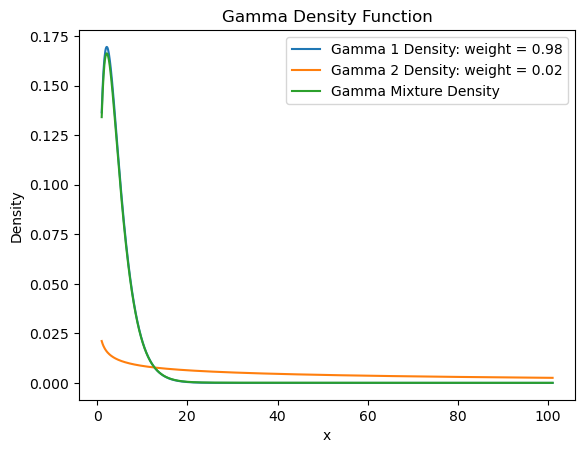

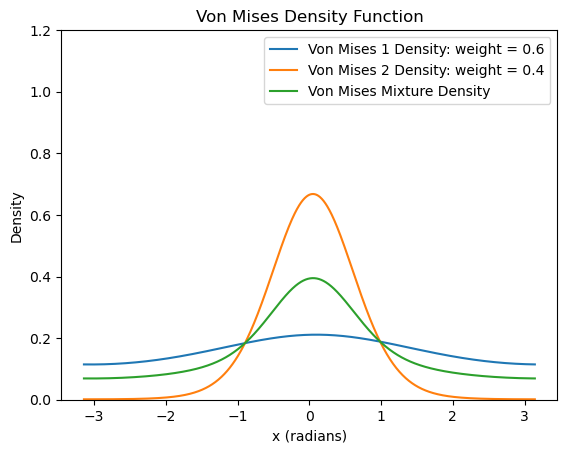

In [78]:
# -------------------------------------------------------------------------
# Define helper functions for calculating Gamma and von Mises log-densities
# -------------------------------------------------------------------------
def gamma_density(x, shape, scale):
    """
    Computes the log of the Gamma density for each value in x.

    Args:
      x (Tensor): Input values for which to compute the density.
      shape (float): Gamma shape parameter
      scale (float): Gamma scale parameter

    Returns:
      Tensor: The log of the Gamma probability density at each x.
    """
    return -1*torch.lgamma(shape) - shape*torch.log(scale) \
           + (shape - 1)*torch.log(x) - x/scale

def vonmises_density(x, kappa, vm_mu):
    """
    Computes the log of the von Mises density for each value in x.

    Args:
      x (Tensor): Input angles in radians.
      kappa (float): Concentration parameter (kappa)
      vm_mu (float): Mean direction parameter (mu)

    Returns:
      Tensor: The log of the von Mises probability density at each x.
    """
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


# -------------------------------------------------------------------------
# Round and display the mixture weights for the Gamma distributions
# -------------------------------------------------------------------------
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)

gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# -------------------------------------------------------------------------
# Round and display the mixture weights for the von Mises distributions
# -------------------------------------------------------------------------
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)

vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# -------------------------------------------------------------------------
# 1. Plotting the Gamma mixture distribution
#    a) Generate x values
#    b) Compute individual Gamma log densities
#    c) Exponentiate and combine using recovered weights
# -------------------------------------------------------------------------
x_values = torch.linspace(1, 101, 1000).to(device)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2)*500)
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) \
                        + gamma_weight2_recovered*torch.exp(gamma2_density)

# Move results to CPU and convert to NumPy for plotting
x_values_np = x_values.cpu().numpy()
gamma1_density_np = np.exp(gamma1_density.cpu().numpy())
gamma2_density_np = np.exp(gamma2_density.cpu().numpy())
gamma_mixture_density_np = gamma_mixture_density.cpu().numpy()

# -------------------------------------------------------------------------
# 2. Plot the Gamma distributions and their mixture
# -------------------------------------------------------------------------
plt.plot(x_values_np, gamma1_density_np, label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values_np, gamma2_density_np, label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values_np, gamma_mixture_density_np, label='Gamma Mixture Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()


# -------------------------------------------------------------------------
# 3. Plotting the von Mises mixture distribution
#    a) Generate x values from -π to π
#    b) Compute individual von Mises log densities
#    c) Exponentiate and combine using recovered weights
# -------------------------------------------------------------------------
x_values = torch.linspace(-np.pi, np.pi, 1000).to(device)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) \
                           + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Move results to CPU and convert to NumPy for plotting
x_values_np = x_values.cpu().numpy()
vonmises1_density_np = np.exp(vonmises1_density.cpu().numpy())
vonmises2_density_np = np.exp(vonmises2_density.cpu().numpy())
vonmises_mixture_density_np = vonmises_mixture_density.cpu().numpy()

# -------------------------------------------------------------------------
# 4. Plot the von Mises distributions and their mixture
# -------------------------------------------------------------------------
plt.plot(x_values_np, vonmises1_density_np, label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values_np, vonmises2_density_np, label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values_np, vonmises_mixture_density_np, label='Von Mises Mixture Density')
plt.xlabel('x (radians)')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.ylim(0, 1.2)  # Set a limit for the y-axis
plt.legend()
plt.show()


## Generate a distribution of movement parameters

To see how variable the movement parameters are across samples, we can generate a distribution of movement parameters from a batch of samples.

We take the code from above that we used to create the DataLoader for the test data and increase the batch size (to get more samples to create the distribution from).

As we're not using the test dataset any more, we'll just put all of the samples in the same batch, and generate movement parameters for all of them.

In [79]:
print(f'There are {len(dataset_test)} samples in the test dataset')
bs = len(dataset_test) # batch size
dataloader_test = DataLoader(dataset=dataset_test, batch_size=bs, shuffle=True)

There are 1010 samples in the test dataset


Take all of the samples from the test dataset and put them in a single batch.

In [80]:
# -----------------------------------------------------------
# Fetch a batch of data from the training dataloader
# -----------------------------------------------------------
x1_batch, x2_batch, x3_batch, labels = next(iter(dataloader_test))

# -----------------------------------------------------------
# Register a forward hook to capture the outputs 
#    from 'fcn_movement_all' during the forward pass
# -----------------------------------------------------------
hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# -----------------------------------------------------------
# Perform a forward pass in evaluation mode to generate 
#    and capture the sub-network's outputs in 'intermediate_output'
# -----------------------------------------------------------
model.eval()  # Disables certain layers like dropout

# Pass the batch through the model
final_output = model((x1_batch, x2_batch, x3_batch))

# -----------------------------------------------------------
# Prepare lists to store the distribution parameters 
#    for each sample in the batch
# -----------------------------------------------------------
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

# -----------------------------------------------------------
# Extract parameters from 'intermediate_output' 
#    for every sample in the batch
# -----------------------------------------------------------
for batch_output in intermediate_output:
    # Each 'batch_output' corresponds to one forward pass;
    # it might contain multiple samples if the batch size > 1
    for sample_output in batch_output:
        # Unpack the 12 parameters of the Gamma and von Mises mixtures
        gamma_shape1, gamma_scale1, gamma_weight1, \
        gamma_shape2, gamma_scale2, gamma_weight2, \
        vonmises_mu1, vonmises_kappa1, vonmises_weight1, \
        vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output

        # Convert log-space parameters to real space, then store
        gamma_shape1_list.append(torch.exp(gamma_shape1).item())
        gamma_scale1_list.append(torch.exp(gamma_scale1).item())
        gamma_weight1_list.append(
            (torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item()
        )
        gamma_shape2_list.append(torch.exp(gamma_shape2).item())
        gamma_scale2_list.append((torch.exp(gamma_scale2)*500).item())  # scale factor 500
        gamma_weight2_list.append(
            (torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item()
        )
        vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
        vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
        vonmises_weight1_list.append(
            (torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item()
        )
        vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
        vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
        vonmises_weight2_list.append(
            (torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item()
        )


### Plot the distribution of movement parameters

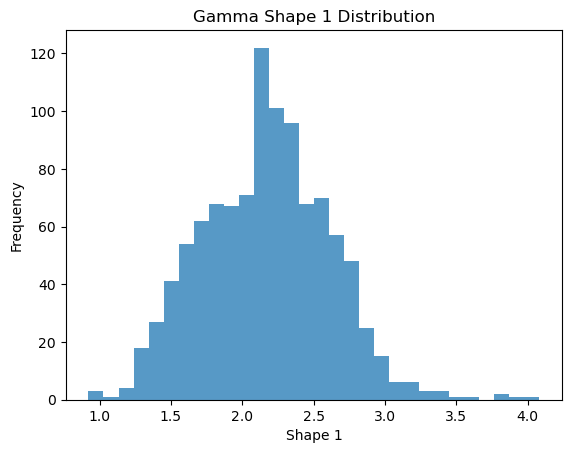

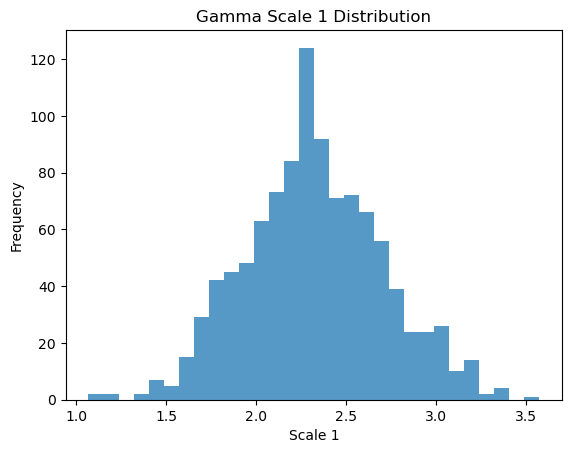

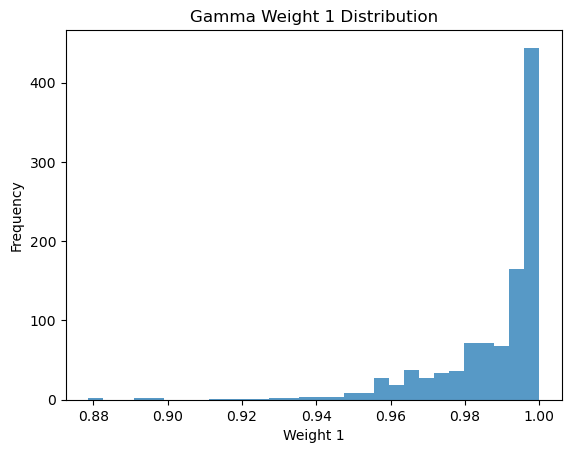

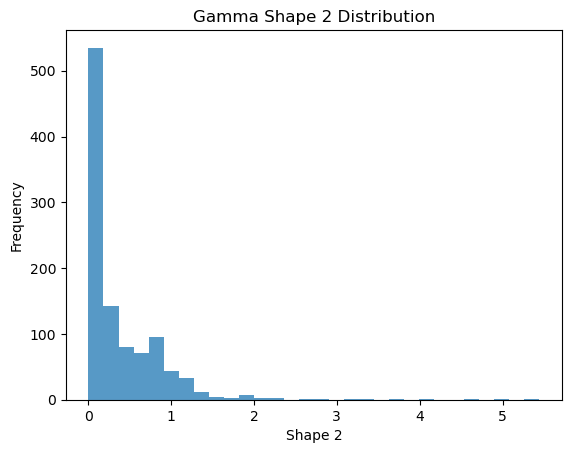

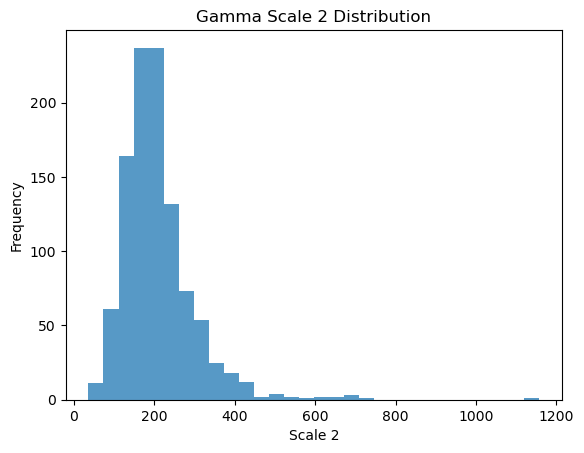

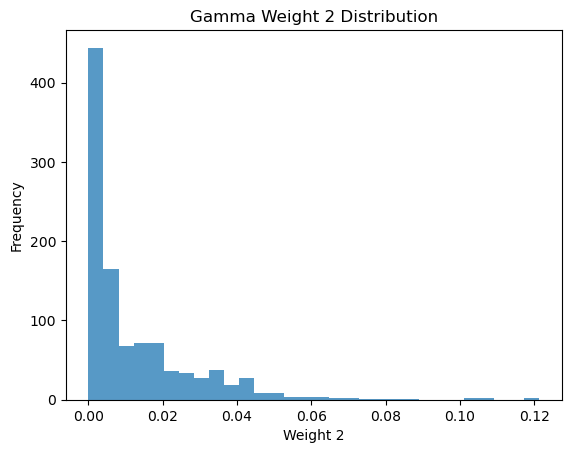

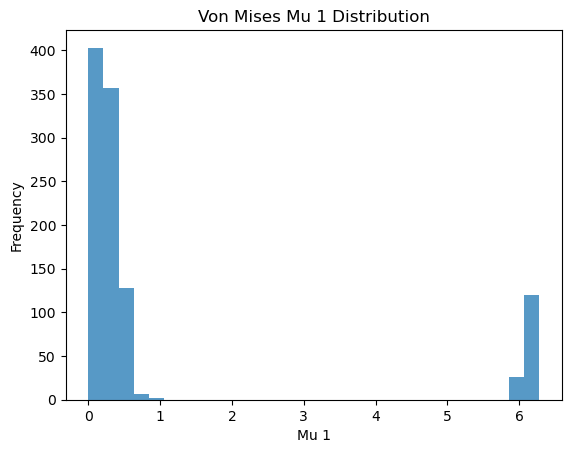

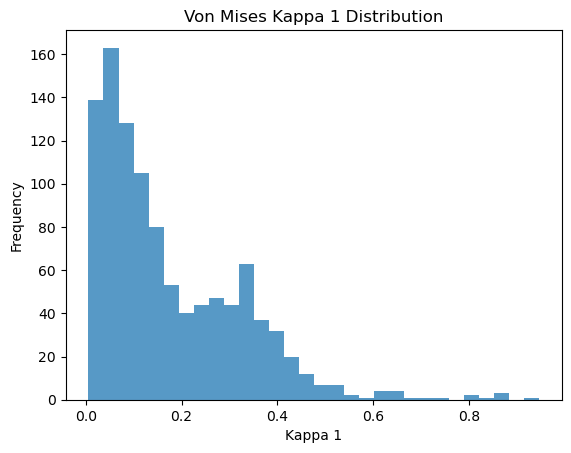

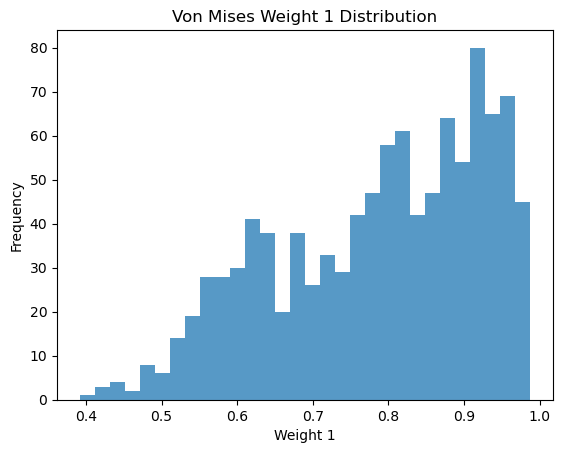

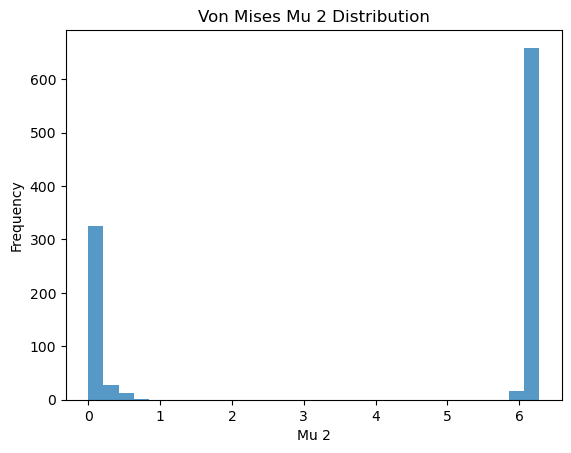

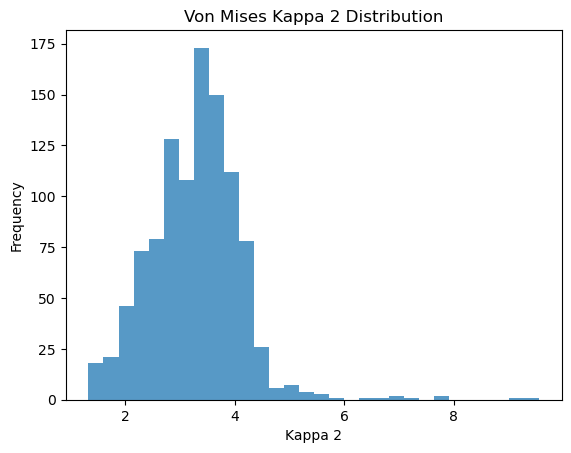

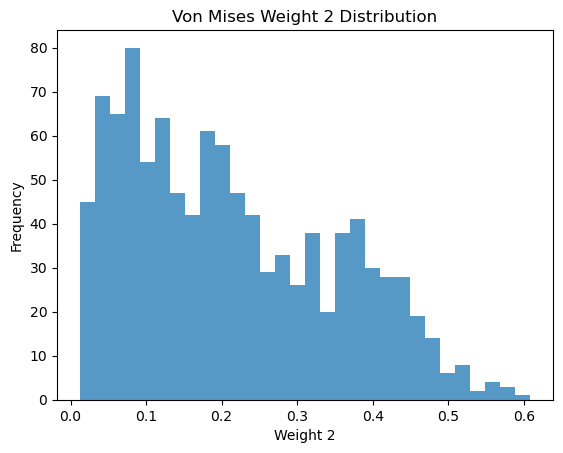

In [81]:
# -----------------------------------------------------------
# Define a helper function to plot histograms 
#    for the collected parameters
# -----------------------------------------------------------
def plot_histogram(data, title, xlabel):
    """
    Plots a histogram of the provided data.

    Args:
        data (list): Data points to plot in a histogram.
        title (str): Title of the histogram plot.
        xlabel (str): X-axis label.
    """
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

# -----------------------------------------------------------
# Plot histograms for each parameter distribution
# -----------------------------------------------------------
plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# -----------------------------------------------------------
# Remove the hook to stop capturing outputs 
#    in subsequent forward passes
# -----------------------------------------------------------
hook_handle.remove()